# Polynomial Regression

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
Auto = pd.read_csv('Auto.csv', sep=',', na_values='?')
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
2,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
3,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
4,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
5,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [3]:
Auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 1 to 397
Data columns (total 9 columns):
mpg             397 non-null float64
cylinders       397 non-null int64
displacement    397 non-null float64
horsepower      392 non-null float64
weight          397 non-null int64
acceleration    397 non-null float64
year            397 non-null int64
origin          397 non-null int64
name            397 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 31.0+ KB


In [4]:
Auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,397.000000,397.000000,397.000000,392.000000,397.000000,397.000000,397.000000,397.000000
mean,23.515869,5.458438,193.532746,104.469388,2970.261965,15.555668,75.994962,1.574307
std,7.825804,1.701577,104.379583,38.491160,847.904119,2.749995,3.690005,0.802549
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.000000,75.000000,2223.000000,13.800000,73.000000,1.000000
50%,23.000000,4.000000,146.000000,93.500000,2800.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3609.000000,17.100000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [5]:
Auto = Auto.dropna()
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
2,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
3,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
4,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
5,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [6]:
X = Auto.loc[:,['horsepower']].astype('float32').values
Y = Auto.loc[:,['mpg']].astype('float32').values

X_train = Auto.loc[:,['horsepower']].astype('float32').values[:317,:]
Y_train = Auto.loc[:,['mpg']].astype('float32').values[:317,:]

X_test = Auto.loc[:,['horsepower']].astype('float32').values[317:,:]
Y_test = Auto.loc[:,['mpg']].astype('float32').values[317:,:]

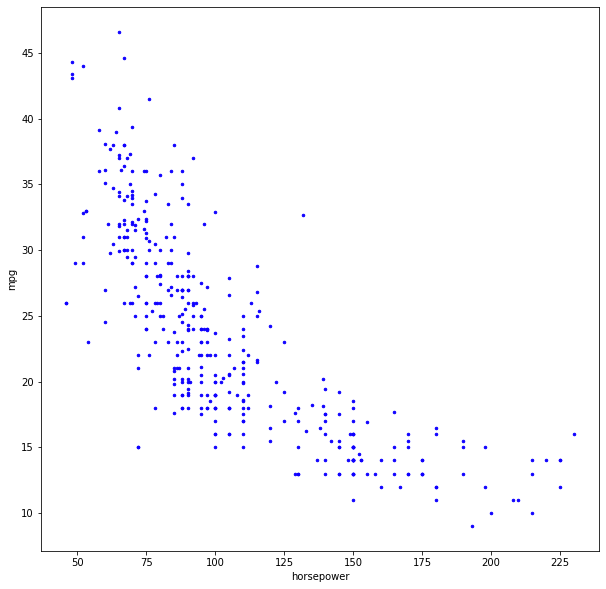

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('horsepower')
ax.set_ylabel('mpg')
ax.plot(X, Y, marker='.', color='#0F00FF', markersize=5, linestyle='')

In [8]:
class Layer1():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []
        self.mu = tf.zeros(shape=(1,self.output_dim), dtype="float32")
        self.sigma = tf.ones(shape=(1,self.output_dim), dtype="float32")

    def __call__(self, inputs):
        return (inputs-self.mu)/self.sigma
    
class Layer2():
    
    def __init__(self, input_dim, degree):
        self.input_dim = input_dim
        self.degree = degree
        self.build()
        
    def build(self):
        self.weights = []

    def __call__(self, inputs):
        m = tf.shape(inputs)[0]
        x = tf.transpose(tf.repeat(inputs, repeats=self.degree, axis=0))
        p = tf.transpose(tf.tile(tf.eye(self.degree,self.degree+1), [m,1]))
        z = tf.math.polyval(p,x)
        return tf.reshape(tf.transpose(z), shape=(m,-1))
    
class Layer3():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        w_init = tf.random.normal(shape=shape, dtype="float32")
        return tf.Variable(initial_value=w_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        return tf.transpose(z)

In [9]:
class LossFunction():
        
    def __init__(self, model):
        self.model = model
            
    def __call__(self, y_true, y_pred):
        return tf.math.reduce_mean(tf.math.square(y_true-y_pred))

In [10]:
class MetricFunction():
    
    def __init__(self, model):
        self.model = model
                    
    def __call__(self, y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs(y_true-y_pred))

In [11]:
class Optimizer():
    
    def __init__(self, model, learning_rate):
        self.model = model
        self.learning_rate = learning_rate
        self.stop_training = False
        
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            weights[i].assign(w - self.learning_rate*grad_w)
            
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:
            H = self.model(X)
            loss = self.model.loss(Y, H)
        grads = tape.gradient(loss, self.model.weights)
        self.apply(grads, self.model.weights)    
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [12]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [13]:
class PolynomialRegression():
    
    def __init__(self, input_dim, output_dim, degree):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.degree = degree
        self.build()
    
    def build(self):
        self.h1 = Layer1(input_dim=self.input_dim, output_dim=self.input_dim)
        self.h2 = Layer2(input_dim=self.input_dim, degree=self.degree)
        self.h3 = Layer3(input_dim=self.degree*self.input_dim, output_dim=self.output_dim)
        self.layers = [self.h1, self.h2, self.h3]
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        a1 = self.h1(inputs)
        a2 = self.h2(a1) 
        y = self.h3(a2)
        return y
        
    def train_setup(self, epochs, learning_rate, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.loss = LossFunction(model=self)
        self.metric = MetricFunction(model=self)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate) 
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=500, error=0.0001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=1000, error=0.0001)]
        
    def fit(self, X, Y, epochs=10000, learning_rate=0.0001, verbose=True):
        self.layers[0].mu = tf.math.reduce_mean(tf.constant(X, dtype="float32"), axis=0)
        self.layers[0].sigma = tf.math.reduce_std(tf.constant(X, dtype="float32"), axis=0)
        self.train_setup(epochs, learning_rate, verbose)
        if verbose:
            print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(self.epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [14]:
polynomial_regression = PolynomialRegression(input_dim=X_train.shape[1], output_dim=Y_train.shape[1], degree=4)

polynomial_regression.fit(X_train, Y_train)

Train on 317 samples
Epochs 1/10000 - Loss: 443.8948669433594 - Metric: 19.741680145263672
----- 0.026s -----
Epochs 2/10000 - Loss: 443.6208190917969 - Metric: 19.735980987548828
----- 0.006s -----
Epochs 3/10000 - Loss: 443.3470458984375 - Metric: 19.730283737182617
----- 0.008s -----
Epochs 4/10000 - Loss: 443.073486328125 - Metric: 19.72458267211914
----- 0.008s -----
Epochs 5/10000 - Loss: 442.79998779296875 - Metric: 19.71888542175293
----- 0.006s -----
Epochs 6/10000 - Loss: 442.52691650390625 - Metric: 19.71318244934082
----- 0.008s -----
Epochs 7/10000 - Loss: 442.2539978027344 - Metric: 19.707481384277344
----- 0.009s -----
Epochs 8/10000 - Loss: 441.9812316894531 - Metric: 19.701778411865234
----- 0.007s -----
Epochs 9/10000 - Loss: 441.7087097167969 - Metric: 19.696077346801758
----- 0.009s -----
Epochs 10/10000 - Loss: 441.4363708496094 - Metric: 19.69037628173828
----- 0.008s -----
Epochs 11/10000 - Loss: 441.16424560546875 - Metric: 19.684673309326172
----- 0.008s -----


----- 0.006s -----
Epochs 93/10000 - Loss: 419.535888671875 - Metric: 19.21977996826172
----- 0.008s -----
Epochs 94/10000 - Loss: 419.2802734375 - Metric: 19.214170455932617
----- 0.007s -----
Epochs 95/10000 - Loss: 419.0247497558594 - Metric: 19.208559036254883
----- 0.006s -----
Epochs 96/10000 - Loss: 418.76947021484375 - Metric: 19.202951431274414
----- 0.007s -----
Epochs 97/10000 - Loss: 418.51434326171875 - Metric: 19.19734764099121
----- 0.007s -----
Epochs 98/10000 - Loss: 418.25946044921875 - Metric: 19.19174575805664
----- 0.006s -----
Epochs 99/10000 - Loss: 418.0047302246094 - Metric: 19.186141967773438
----- 0.008s -----
Epochs 100/10000 - Loss: 417.75018310546875 - Metric: 19.180540084838867
----- 0.006s -----
Epochs 101/10000 - Loss: 417.495849609375 - Metric: 19.174943923950195
----- 0.006s -----
Epochs 102/10000 - Loss: 417.2417297363281 - Metric: 19.16934585571289
----- 0.008s -----
Epochs 103/10000 - Loss: 416.98773193359375 - Metric: 19.16375160217285
----- 0.007

----- 0.007s -----
Epochs 184/10000 - Loss: 397.030029296875 - Metric: 18.716611862182617
----- 0.007s -----
Epochs 185/10000 - Loss: 396.7910461425781 - Metric: 18.711166381835938
----- 0.005s -----
Epochs 186/10000 - Loss: 396.5522155761719 - Metric: 18.705724716186523
----- 0.006s -----
Epochs 187/10000 - Loss: 396.3136291503906 - Metric: 18.70028305053711
----- 0.007s -----
Epochs 188/10000 - Loss: 396.07513427734375 - Metric: 18.69484519958496
----- 0.005s -----
Epochs 189/10000 - Loss: 395.8368835449219 - Metric: 18.689409255981445
----- 0.006s -----
Epochs 190/10000 - Loss: 395.5987548828125 - Metric: 18.68397331237793
----- 0.008s -----
Epochs 191/10000 - Loss: 395.3608093261719 - Metric: 18.678539276123047
----- 0.007s -----
Epochs 192/10000 - Loss: 395.1230163574219 - Metric: 18.673107147216797
----- 0.006s -----
Epochs 193/10000 - Loss: 394.88543701171875 - Metric: 18.667678833007812
----- 0.007s -----
Epochs 194/10000 - Loss: 394.6480407714844 - Metric: 18.662250518798828
-

----- 0.006s -----
Epochs 275/10000 - Loss: 375.9880676269531 - Metric: 18.228721618652344
----- 0.008s -----
Epochs 276/10000 - Loss: 375.7646179199219 - Metric: 18.22344398498535
----- 0.007s -----
Epochs 277/10000 - Loss: 375.5412292480469 - Metric: 18.218168258666992
----- 0.005s -----
Epochs 278/10000 - Loss: 375.318115234375 - Metric: 18.212894439697266
----- 0.007s -----
Epochs 279/10000 - Loss: 375.0950927734375 - Metric: 18.207624435424805
----- 0.009s -----
Epochs 280/10000 - Loss: 374.8722839355469 - Metric: 18.20235252380371
----- 0.006s -----
Epochs 281/10000 - Loss: 374.64959716796875 - Metric: 18.197086334228516
----- 0.006s -----
Epochs 282/10000 - Loss: 374.4270935058594 - Metric: 18.191818237304688
----- 0.008s -----
Epochs 283/10000 - Loss: 374.2047424316406 - Metric: 18.186552047729492
----- 0.006s -----
Epochs 284/10000 - Loss: 373.98260498046875 - Metric: 18.181291580200195
----- 0.006s -----
Epochs 285/10000 - Loss: 373.7605285644531 - Metric: 18.1760311126709
--

----- 0.007s -----
Epochs 366/10000 - Loss: 356.30657958984375 - Metric: 17.755796432495117
----- 0.006s -----
Epochs 367/10000 - Loss: 356.0975036621094 - Metric: 17.750680923461914
----- 0.006s -----
Epochs 368/10000 - Loss: 355.8885803222656 - Metric: 17.745569229125977
----- 0.007s -----
Epochs 369/10000 - Loss: 355.6798095703125 - Metric: 17.74045753479004
----- 0.006s -----
Epochs 370/10000 - Loss: 355.47113037109375 - Metric: 17.7353458404541
----- 0.006s -----
Epochs 371/10000 - Loss: 355.2626647949219 - Metric: 17.730236053466797
----- 0.008s -----
Epochs 372/10000 - Loss: 355.05438232421875 - Metric: 17.725130081176758
----- 0.007s -----
Epochs 373/10000 - Loss: 354.84619140625 - Metric: 17.72002410888672
----- 0.006s -----
Epochs 374/10000 - Loss: 354.6381530761719 - Metric: 17.714921951293945
----- 0.009s -----
Epochs 375/10000 - Loss: 354.4302978515625 - Metric: 17.709819793701172
----- 0.009s -----
Epochs 376/10000 - Loss: 354.2225341796875 - Metric: 17.70471954345703
---

----- 0.009s -----
Epochs 457/10000 - Loss: 337.8896789550781 - Metric: 17.297344207763672
----- 0.007s -----
Epochs 458/10000 - Loss: 337.6940002441406 - Metric: 17.292387008666992
----- 0.007s -----
Epochs 459/10000 - Loss: 337.49847412109375 - Metric: 17.28742790222168
----- 0.006s -----
Epochs 460/10000 - Loss: 337.30303955078125 - Metric: 17.282470703125
----- 0.009s -----
Epochs 461/10000 - Loss: 337.1077575683594 - Metric: 17.277515411376953
----- 0.007s -----
Epochs 462/10000 - Loss: 336.9126281738281 - Metric: 17.272560119628906
----- 0.006s -----
Epochs 463/10000 - Loss: 336.7176513671875 - Metric: 17.26761245727539
----- 0.007s -----
Epochs 464/10000 - Loss: 336.5227966308594 - Metric: 17.26266098022461
----- 0.007s -----
Epochs 465/10000 - Loss: 336.3280944824219 - Metric: 17.257713317871094
----- 0.006s -----
Epochs 466/10000 - Loss: 336.1335144042969 - Metric: 17.25276756286621
----- 0.007s -----
Epochs 467/10000 - Loss: 335.9391174316406 - Metric: 17.247825622558594
----

----- 0.006s -----
Epochs 548/10000 - Loss: 320.6486511230469 - Metric: 16.852869033813477
----- 0.006s -----
Epochs 549/10000 - Loss: 320.46539306640625 - Metric: 16.848060607910156
----- 0.007s -----
Epochs 550/10000 - Loss: 320.2823486328125 - Metric: 16.84325408935547
----- 0.007s -----
Epochs 551/10000 - Loss: 320.09930419921875 - Metric: 16.83844757080078
----- 0.009s -----
Epochs 552/10000 - Loss: 319.91650390625 - Metric: 16.83364486694336
----- 0.007s -----
Epochs 553/10000 - Loss: 319.7337951660156 - Metric: 16.828842163085938
----- 0.007s -----
Epochs 554/10000 - Loss: 319.5511779785156 - Metric: 16.824039459228516
----- 0.007s -----
Epochs 555/10000 - Loss: 319.3687438964844 - Metric: 16.819244384765625
----- 0.006s -----
Epochs 556/10000 - Loss: 319.1864013671875 - Metric: 16.8144474029541
----- 0.007s -----
Epochs 557/10000 - Loss: 319.00421142578125 - Metric: 16.809650421142578
----- 0.008s -----
Epochs 558/10000 - Loss: 318.8221435546875 - Metric: 16.804859161376953
---

----- 0.005s -----
Epochs 639/10000 - Loss: 304.5013732910156 - Metric: 16.421899795532227
----- 0.008s -----
Epochs 640/10000 - Loss: 304.3297119140625 - Metric: 16.417238235473633
----- 0.008s -----
Epochs 641/10000 - Loss: 304.1581726074219 - Metric: 16.412578582763672
----- 0.007s -----
Epochs 642/10000 - Loss: 303.9867858886719 - Metric: 16.40791893005371
----- 0.006s -----
Epochs 643/10000 - Loss: 303.81549072265625 - Metric: 16.403261184692383
----- 0.009s -----
Epochs 644/10000 - Loss: 303.64434814453125 - Metric: 16.398603439331055
----- 0.008s -----
Epochs 645/10000 - Loss: 303.4732971191406 - Metric: 16.393949508666992
----- 0.006s -----
Epochs 646/10000 - Loss: 303.3023681640625 - Metric: 16.38929557800293
----- 0.006s -----
Epochs 647/10000 - Loss: 303.131591796875 - Metric: 16.3846435546875
----- 0.007s -----
Epochs 648/10000 - Loss: 302.96087646484375 - Metric: 16.379993438720703
----- 0.008s -----
Epochs 649/10000 - Loss: 302.79034423828125 - Metric: 16.375347137451172


----- 0.006s -----
Epochs 730/10000 - Loss: 289.3717346191406 - Metric: 16.003982543945312
----- 0.008s -----
Epochs 731/10000 - Loss: 289.21087646484375 - Metric: 15.999462127685547
----- 0.006s -----
Epochs 732/10000 - Loss: 289.0501403808594 - Metric: 15.994941711425781
----- 0.007s -----
Epochs 733/10000 - Loss: 288.88946533203125 - Metric: 15.990424156188965
----- 0.008s -----
Epochs 734/10000 - Loss: 288.72894287109375 - Metric: 15.985904693603516
----- 0.008s -----
Epochs 735/10000 - Loss: 288.5685119628906 - Metric: 15.981390953063965
----- 0.006s -----
Epochs 736/10000 - Loss: 288.4082336425781 - Metric: 15.976875305175781
----- 0.006s -----
Epochs 737/10000 - Loss: 288.2480163574219 - Metric: 15.972362518310547
----- 0.009s -----
Epochs 738/10000 - Loss: 288.0879211425781 - Metric: 15.967853546142578
----- 0.008s -----
Epochs 739/10000 - Loss: 287.9279479980469 - Metric: 15.96334457397461
----- 0.006s -----
Epochs 740/10000 - Loss: 287.76812744140625 - Metric: 15.958834648132

Epochs 820/10000 - Loss: 275.3401794433594 - Metric: 15.60306453704834
----- 0.006s -----
Epochs 821/10000 - Loss: 275.1892395019531 - Metric: 15.598677635192871
----- 0.008s -----
Epochs 822/10000 - Loss: 275.0384216308594 - Metric: 15.594292640686035
----- 0.008s -----
Epochs 823/10000 - Loss: 274.8876647949219 - Metric: 15.589906692504883
----- 0.006s -----
Epochs 824/10000 - Loss: 274.7370300292969 - Metric: 15.585524559020996
----- 0.005s -----
Epochs 825/10000 - Loss: 274.5865173339844 - Metric: 15.58114242553711
----- 0.007s -----
Epochs 826/10000 - Loss: 274.4361572265625 - Metric: 15.576765060424805
----- 0.008s -----
Epochs 827/10000 - Loss: 274.2857971191406 - Metric: 15.572385787963867
----- 0.006s -----
Epochs 828/10000 - Loss: 274.1355895996094 - Metric: 15.568011283874512
----- 0.007s -----
Epochs 829/10000 - Loss: 273.9855041503906 - Metric: 15.563633918762207
----- 0.007s -----
Epochs 830/10000 - Loss: 273.83551025390625 - Metric: 15.559259414672852
----- 0.007s -----


----- 0.008s -----
Epochs 911/10000 - Loss: 262.0301818847656 - Metric: 15.209813117980957
----- 0.006s -----
Epochs 912/10000 - Loss: 261.8885803222656 - Metric: 15.205556869506836
----- 0.008s -----
Epochs 913/10000 - Loss: 261.7470703125 - Metric: 15.20130443572998
----- 0.008s -----
Epochs 914/10000 - Loss: 261.605712890625 - Metric: 15.197051048278809
----- 0.006s -----
Epochs 915/10000 - Loss: 261.46441650390625 - Metric: 15.192801475524902
----- 0.006s -----
Epochs 916/10000 - Loss: 261.3232116699219 - Metric: 15.188551902770996
----- 0.009s -----
Epochs 917/10000 - Loss: 261.1820983886719 - Metric: 15.184304237365723
----- 0.007s -----
Epochs 918/10000 - Loss: 261.0411071777344 - Metric: 15.180057525634766
----- 0.008s -----
Epochs 919/10000 - Loss: 260.9001770019531 - Metric: 15.175811767578125
----- 0.006s -----
Epochs 920/10000 - Loss: 260.7593994140625 - Metric: 15.171568870544434
----- 0.007s -----
Epochs 921/10000 - Loss: 260.6186828613281 - Metric: 15.167325019836426
---

----- 0.006s -----
Epochs 1001/10000 - Loss: 249.67503356933594 - Metric: 14.832474708557129
----- 0.007s -----
Epochs 1002/10000 - Loss: 249.5420379638672 - Metric: 14.828347206115723
----- 0.01s -----
Epochs 1003/10000 - Loss: 249.40916442871094 - Metric: 14.82421875
----- 0.008s -----
Epochs 1004/10000 - Loss: 249.2763671875 - Metric: 14.820090293884277
----- 0.006s -----
Epochs 1005/10000 - Loss: 249.1436767578125 - Metric: 14.81596565246582
----- 0.006s -----
Epochs 1006/10000 - Loss: 249.01109313964844 - Metric: 14.81184196472168
----- 0.008s -----
Epochs 1007/10000 - Loss: 248.87857055664062 - Metric: 14.807719230651855
----- 0.007s -----
Epochs 1008/10000 - Loss: 248.74610900878906 - Metric: 14.803598403930664
----- 0.006s -----
Epochs 1009/10000 - Loss: 248.6138153076172 - Metric: 14.799479484558105
----- 0.006s -----
Epochs 1010/10000 - Loss: 248.48158264160156 - Metric: 14.795360565185547
----- 0.007s -----
Epochs 1011/10000 - Loss: 248.3494415283203 - Metric: 14.79124355316

----- 0.007s -----
Epochs 1090/10000 - Loss: 238.19454956054688 - Metric: 14.470290184020996
----- 0.007s -----
Epochs 1091/10000 - Loss: 238.06947326660156 - Metric: 14.466285705566406
----- 0.007s -----
Epochs 1092/10000 - Loss: 237.94454956054688 - Metric: 14.462276458740234
----- 0.007s -----
Epochs 1093/10000 - Loss: 237.8197021484375 - Metric: 14.458271026611328
----- 0.007s -----
Epochs 1094/10000 - Loss: 237.69491577148438 - Metric: 14.454264640808105
----- 0.008s -----
Epochs 1095/10000 - Loss: 237.57028198242188 - Metric: 14.450261116027832
----- 0.008s -----
Epochs 1096/10000 - Loss: 237.44566345214844 - Metric: 14.446258544921875
----- 0.006s -----
Epochs 1097/10000 - Loss: 237.32118225097656 - Metric: 14.442256927490234
----- 0.006s -----
Epochs 1098/10000 - Loss: 237.19676208496094 - Metric: 14.438258171081543
----- 0.007s -----
Epochs 1099/10000 - Loss: 237.07240295410156 - Metric: 14.434259414672852
----- 0.009s -----
Epochs 1100/10000 - Loss: 236.9481658935547 - Metric

----- 0.006s -----
Epochs 1179/10000 - Loss: 227.3981170654297 - Metric: 14.118650436401367
----- 0.007s -----
Epochs 1180/10000 - Loss: 227.280517578125 - Metric: 14.114758491516113
----- 0.006s -----
Epochs 1181/10000 - Loss: 227.1630096435547 - Metric: 14.110867500305176
----- 0.007s -----
Epochs 1182/10000 - Loss: 227.04559326171875 - Metric: 14.106976509094238
----- 0.007s -----
Epochs 1183/10000 - Loss: 226.92823791503906 - Metric: 14.103087425231934
----- 0.007s -----
Epochs 1184/10000 - Loss: 226.81097412109375 - Metric: 14.099201202392578
----- 0.006s -----
Epochs 1185/10000 - Loss: 226.69375610351562 - Metric: 14.095314979553223
----- 0.005s -----
Epochs 1186/10000 - Loss: 226.57664489746094 - Metric: 14.0914306640625
----- 0.008s -----
Epochs 1187/10000 - Loss: 226.45962524414062 - Metric: 14.087545394897461
----- 0.008s -----
Epochs 1188/10000 - Loss: 226.34266662597656 - Metric: 14.083663940429688
----- 0.006s -----
Epochs 1189/10000 - Loss: 226.22576904296875 - Metric: 14

----- 0.008s -----
Epochs 1268/10000 - Loss: 217.24066162109375 - Metric: 13.777209281921387
----- 0.007s -----
Epochs 1269/10000 - Loss: 217.1300048828125 - Metric: 13.773431777954102
----- 0.006s -----
Epochs 1270/10000 - Loss: 217.01943969726562 - Metric: 13.7696533203125
----- 0.007s -----
Epochs 1271/10000 - Loss: 216.9088897705078 - Metric: 13.765875816345215
----- 0.008s -----
Epochs 1272/10000 - Loss: 216.79847717285156 - Metric: 13.762097358703613
----- 0.008s -----
Epochs 1273/10000 - Loss: 216.6881103515625 - Metric: 13.758323669433594
----- 0.006s -----
Epochs 1274/10000 - Loss: 216.5778350830078 - Metric: 13.754549980163574
----- 0.007s -----
Epochs 1275/10000 - Loss: 216.46762084960938 - Metric: 13.750778198242188
----- 0.006s -----
Epochs 1276/10000 - Loss: 216.35748291015625 - Metric: 13.747007369995117
----- 0.008s -----
Epochs 1277/10000 - Loss: 216.24740600585938 - Metric: 13.74323844909668
----- 0.008s -----
Epochs 1278/10000 - Loss: 216.13742065429688 - Metric: 13.

----- 0.006s -----
Epochs 1357/10000 - Loss: 207.6800079345703 - Metric: 13.448698043823242
----- 0.008s -----
Epochs 1358/10000 - Loss: 207.5758056640625 - Metric: 13.445184707641602
----- 0.006s -----
Epochs 1359/10000 - Loss: 207.47171020507812 - Metric: 13.441672325134277
----- 0.006s -----
Epochs 1360/10000 - Loss: 207.36767578125 - Metric: 13.438162803649902
----- 0.008s -----
Epochs 1361/10000 - Loss: 207.26370239257812 - Metric: 13.434652328491211
----- 0.007s -----
Epochs 1362/10000 - Loss: 207.15980529785156 - Metric: 13.431142807006836
----- 0.005s -----
Epochs 1363/10000 - Loss: 207.05596923828125 - Metric: 13.427634239196777
----- 0.007s -----
Epochs 1364/10000 - Loss: 206.95220947265625 - Metric: 13.424128532409668
----- 0.007s -----
Epochs 1365/10000 - Loss: 206.84852600097656 - Metric: 13.420622825622559
----- 0.007s -----
Epochs 1366/10000 - Loss: 206.744873046875 - Metric: 13.417119979858398
----- 0.007s -----
Epochs 1367/10000 - Loss: 206.6413116455078 - Metric: 13.4

----- 0.007s -----
Epochs 1446/10000 - Loss: 198.6768798828125 - Metric: 13.140381813049316
----- 0.007s -----
Epochs 1447/10000 - Loss: 198.57875061035156 - Metric: 13.136966705322266
----- 0.007s -----
Epochs 1448/10000 - Loss: 198.48065185546875 - Metric: 13.133551597595215
----- 0.007s -----
Epochs 1449/10000 - Loss: 198.38265991210938 - Metric: 13.13014030456543
----- 0.006s -----
Epochs 1450/10000 - Loss: 198.28472900390625 - Metric: 13.126728057861328
----- 0.008s -----
Epochs 1451/10000 - Loss: 198.18685913085938 - Metric: 13.123319625854492
----- 0.007s -----
Epochs 1452/10000 - Loss: 198.0890655517578 - Metric: 13.119911193847656
----- 0.006s -----
Epochs 1453/10000 - Loss: 197.99131774902344 - Metric: 13.116501808166504
----- 0.007s -----
Epochs 1454/10000 - Loss: 197.89366149902344 - Metric: 13.113096237182617
----- 0.007s -----
Epochs 1455/10000 - Loss: 197.79603576660156 - Metric: 13.109688758850098
----- 0.006s -----
Epochs 1456/10000 - Loss: 197.69850158691406 - Metric:

----- 0.009s -----
Epochs 1535/10000 - Loss: 190.1949462890625 - Metric: 12.840697288513184
----- 0.008s -----
Epochs 1536/10000 - Loss: 190.1024932861328 - Metric: 12.837376594543457
----- 0.007s -----
Epochs 1537/10000 - Loss: 190.0100555419922 - Metric: 12.834059715270996
----- 0.008s -----
Epochs 1538/10000 - Loss: 189.91769409179688 - Metric: 12.830741882324219
----- 0.009s -----
Epochs 1539/10000 - Loss: 189.82540893554688 - Metric: 12.82742691040039
----- 0.007s -----
Epochs 1540/10000 - Loss: 189.73318481445312 - Metric: 12.824110984802246
----- 0.007s -----
Epochs 1541/10000 - Loss: 189.64102172851562 - Metric: 12.820796966552734
----- 0.006s -----
Epochs 1542/10000 - Loss: 189.5489044189453 - Metric: 12.817483901977539
----- 0.008s -----
Epochs 1543/10000 - Loss: 189.45687866210938 - Metric: 12.814172744750977
----- 0.008s -----
Epochs 1544/10000 - Loss: 189.36489868164062 - Metric: 12.810860633850098
----- 0.006s -----
Epochs 1545/10000 - Loss: 189.27297973632812 - Metric: 1

----- 0.006s -----
Epochs 1624/10000 - Loss: 182.20034790039062 - Metric: 12.549370765686035
----- 0.009s -----
Epochs 1625/10000 - Loss: 182.11317443847656 - Metric: 12.546144485473633
----- 0.008s -----
Epochs 1626/10000 - Loss: 182.0260467529297 - Metric: 12.542917251586914
----- 0.006s -----
Epochs 1627/10000 - Loss: 181.93898010253906 - Metric: 12.539692878723145
----- 0.008s -----
Epochs 1628/10000 - Loss: 181.8519744873047 - Metric: 12.536469459533691
----- 0.007s -----
Epochs 1629/10000 - Loss: 181.76502990722656 - Metric: 12.533246040344238
----- 0.007s -----
Epochs 1630/10000 - Loss: 181.67813110351562 - Metric: 12.530036926269531
----- 0.01s -----
Epochs 1631/10000 - Loss: 181.59129333496094 - Metric: 12.526871681213379
----- 0.006s -----
Epochs 1632/10000 - Loss: 181.5045166015625 - Metric: 12.52370548248291
----- 0.007s -----
Epochs 1633/10000 - Loss: 181.41778564453125 - Metric: 12.520541191101074
----- 0.008s -----
Epochs 1634/10000 - Loss: 181.33114624023438 - Metric: 1

----- 0.007s -----
Epochs 1713/10000 - Loss: 174.66162109375 - Metric: 12.270554542541504
----- 0.007s -----
Epochs 1714/10000 - Loss: 174.57937622070312 - Metric: 12.267468452453613
----- 0.006s -----
Epochs 1715/10000 - Loss: 174.49720764160156 - Metric: 12.264385223388672
----- 0.006s -----
Epochs 1716/10000 - Loss: 174.4150848388672 - Metric: 12.261301040649414
----- 0.008s -----
Epochs 1717/10000 - Loss: 174.33302307128906 - Metric: 12.258218765258789
----- 0.006s -----
Epochs 1718/10000 - Loss: 174.25099182128906 - Metric: 12.255136489868164
----- 0.007s -----
Epochs 1719/10000 - Loss: 174.1690216064453 - Metric: 12.252057075500488
----- 0.008s -----
Epochs 1720/10000 - Loss: 174.08714294433594 - Metric: 12.248976707458496
----- 0.006s -----
Epochs 1721/10000 - Loss: 174.00527954101562 - Metric: 12.245899200439453
----- 0.006s -----
Epochs 1722/10000 - Loss: 173.9234619140625 - Metric: 12.242820739746094
----- 0.008s -----
Epochs 1723/10000 - Loss: 173.84173583984375 - Metric: 12

----- 0.006s -----
Epochs 1802/10000 - Loss: 167.54937744140625 - Metric: 11.9996919631958
----- 0.006s -----
Epochs 1803/10000 - Loss: 167.47178649902344 - Metric: 11.99669075012207
----- 0.008s -----
Epochs 1804/10000 - Loss: 167.3942413330078 - Metric: 11.993691444396973
----- 0.008s -----
Epochs 1805/10000 - Loss: 167.31675720214844 - Metric: 11.990693092346191
----- 0.005s -----
Epochs 1806/10000 - Loss: 167.23928833007812 - Metric: 11.98769474029541
----- 0.008s -----
Epochs 1807/10000 - Loss: 167.1619110107422 - Metric: 11.984697341918945
----- 0.007s -----
Epochs 1808/10000 - Loss: 167.08456420898438 - Metric: 11.981700897216797
----- 0.006s -----
Epochs 1809/10000 - Loss: 167.00726318359375 - Metric: 11.978705406188965
----- 0.007s -----
Epochs 1810/10000 - Loss: 166.93003845214844 - Metric: 11.975711822509766
----- 0.007s -----
Epochs 1811/10000 - Loss: 166.8528289794922 - Metric: 11.972718238830566
----- 0.006s -----
Epochs 1812/10000 - Loss: 166.77569580078125 - Metric: 11.

----- 0.008s -----
Epochs 1891/10000 - Loss: 160.8364715576172 - Metric: 11.737951278686523
----- 0.006s -----
Epochs 1892/10000 - Loss: 160.76321411132812 - Metric: 11.735087394714355
----- 0.008s -----
Epochs 1893/10000 - Loss: 160.6899871826172 - Metric: 11.732223510742188
----- 0.007s -----
Epochs 1894/10000 - Loss: 160.6168212890625 - Metric: 11.729362487792969
----- 0.006s -----
Epochs 1895/10000 - Loss: 160.54371643066406 - Metric: 11.726500511169434
----- 0.006s -----
Epochs 1896/10000 - Loss: 160.47064208984375 - Metric: 11.723641395568848
----- 0.008s -----
Epochs 1897/10000 - Loss: 160.39764404296875 - Metric: 11.720780372619629
----- 0.005s -----
Epochs 1898/10000 - Loss: 160.32464599609375 - Metric: 11.71792221069336
----- 0.006s -----
Epochs 1899/10000 - Loss: 160.25173950195312 - Metric: 11.715063095092773
----- 0.007s -----
Epochs 1900/10000 - Loss: 160.17884826660156 - Metric: 11.712206840515137
----- 0.006s -----
Epochs 1901/10000 - Loss: 160.10601806640625 - Metric: 

----- 0.007s -----
Epochs 1980/10000 - Loss: 154.49742126464844 - Metric: 11.4864501953125
----- 0.007s -----
Epochs 1981/10000 - Loss: 154.42825317382812 - Metric: 11.483663558959961
----- 0.006s -----
Epochs 1982/10000 - Loss: 154.3590850830078 - Metric: 11.480875968933105
----- 0.007s -----
Epochs 1983/10000 - Loss: 154.29000854492188 - Metric: 11.4780912399292
----- 0.006s -----
Epochs 1984/10000 - Loss: 154.22091674804688 - Metric: 11.475305557250977
----- 0.008s -----
Epochs 1985/10000 - Loss: 154.1519012451172 - Metric: 11.472522735595703
----- 0.007s -----
Epochs 1986/10000 - Loss: 154.08294677734375 - Metric: 11.469738960266113
----- 0.007s -----
Epochs 1987/10000 - Loss: 154.0139923095703 - Metric: 11.466957092285156
----- 0.007s -----
Epochs 1988/10000 - Loss: 153.9451141357422 - Metric: 11.4641752243042
----- 0.008s -----
Epochs 1989/10000 - Loss: 153.87628173828125 - Metric: 11.461396217346191
----- 0.006s -----
Epochs 1990/10000 - Loss: 153.8074951171875 - Metric: 11.4586

----- 0.008s -----
Epochs 2069/10000 - Loss: 148.50865173339844 - Metric: 11.244454383850098
----- 0.008s -----
Epochs 2070/10000 - Loss: 148.4432830810547 - Metric: 11.241795539855957
----- 0.007s -----
Epochs 2071/10000 - Loss: 148.37794494628906 - Metric: 11.239137649536133
----- 0.005s -----
Epochs 2072/10000 - Loss: 148.31263732910156 - Metric: 11.236480712890625
----- 0.007s -----
Epochs 2073/10000 - Loss: 148.2473602294922 - Metric: 11.233823776245117
----- 0.006s -----
Epochs 2074/10000 - Loss: 148.18215942382812 - Metric: 11.23116683959961
----- 0.005s -----
Epochs 2075/10000 - Loss: 148.11695861816406 - Metric: 11.228513717651367
----- 0.007s -----
Epochs 2076/10000 - Loss: 148.0518341064453 - Metric: 11.225859642028809
----- 0.005s -----
Epochs 2077/10000 - Loss: 147.9867401123047 - Metric: 11.223206520080566
----- 0.006s -----
Epochs 2078/10000 - Loss: 147.9216766357422 - Metric: 11.220553398132324
----- 0.006s -----
Epochs 2079/10000 - Loss: 147.85665893554688 - Metric: 11

----- 0.006s -----
Epochs 2158/10000 - Loss: 142.84812927246094 - Metric: 11.010942459106445
----- 0.006s -----
Epochs 2159/10000 - Loss: 142.78634643554688 - Metric: 11.008355140686035
----- 0.007s -----
Epochs 2160/10000 - Loss: 142.7245635986328 - Metric: 11.005768775939941
----- 0.007s -----
Epochs 2161/10000 - Loss: 142.66282653808594 - Metric: 11.003181457519531
----- 0.006s -----
Epochs 2162/10000 - Loss: 142.60113525390625 - Metric: 11.000595092773438
----- 0.008s -----
Epochs 2163/10000 - Loss: 142.53945922851562 - Metric: 10.998011589050293
----- 0.006s -----
Epochs 2164/10000 - Loss: 142.47781372070312 - Metric: 10.995426177978516
----- 0.006s -----
Epochs 2165/10000 - Loss: 142.416259765625 - Metric: 10.992841720581055
----- 0.007s -----
Epochs 2166/10000 - Loss: 142.35470581054688 - Metric: 10.990260124206543
----- 0.007s -----
Epochs 2167/10000 - Loss: 142.29322814941406 - Metric: 10.987677574157715
----- 0.006s -----
Epochs 2168/10000 - Loss: 142.23175048828125 - Metric:

----- 0.005s -----
Epochs 2247/10000 - Loss: 137.49542236328125 - Metric: 10.78557300567627
----- 0.007s -----
Epochs 2248/10000 - Loss: 137.4369659423828 - Metric: 10.783095359802246
----- 0.007s -----
Epochs 2249/10000 - Loss: 137.3785400390625 - Metric: 10.780618667602539
----- 0.006s -----
Epochs 2250/10000 - Loss: 137.32012939453125 - Metric: 10.778141975402832
----- 0.006s -----
Epochs 2251/10000 - Loss: 137.26177978515625 - Metric: 10.775667190551758
----- 0.006s -----
Epochs 2252/10000 - Loss: 137.2034454345703 - Metric: 10.773192405700684
----- 0.007s -----
Epochs 2253/10000 - Loss: 137.14515686035156 - Metric: 10.77071762084961
----- 0.006s -----
Epochs 2254/10000 - Loss: 137.0869140625 - Metric: 10.768244743347168
----- 0.007s -----
Epochs 2255/10000 - Loss: 137.0286865234375 - Metric: 10.765771865844727
----- 0.007s -----
Epochs 2256/10000 - Loss: 136.9705047607422 - Metric: 10.763299942016602
----- 0.007s -----
Epochs 2257/10000 - Loss: 136.91238403320312 - Metric: 10.7608

----- 0.007s -----
Epochs 2336/10000 - Loss: 132.4313201904297 - Metric: 10.567914009094238
----- 0.006s -----
Epochs 2337/10000 - Loss: 132.3760223388672 - Metric: 10.565500259399414
----- 0.006s -----
Epochs 2338/10000 - Loss: 132.32070922851562 - Metric: 10.563088417053223
----- 0.007s -----
Epochs 2339/10000 - Loss: 132.2654571533203 - Metric: 10.560676574707031
----- 0.006s -----
Epochs 2340/10000 - Loss: 132.21022033691406 - Metric: 10.558265686035156
----- 0.006s -----
Epochs 2341/10000 - Loss: 132.15501403808594 - Metric: 10.555854797363281
----- 0.007s -----
Epochs 2342/10000 - Loss: 132.09986877441406 - Metric: 10.553445816040039
----- 0.007s -----
Epochs 2343/10000 - Loss: 132.0447235107422 - Metric: 10.551036834716797
----- 0.006s -----
Epochs 2344/10000 - Loss: 131.98965454101562 - Metric: 10.548629760742188
----- 0.006s -----
Epochs 2345/10000 - Loss: 131.93458557128906 - Metric: 10.546220779418945
----- 0.008s -----
Epochs 2346/10000 - Loss: 131.8795623779297 - Metric: 1

----- 0.007s -----
Epochs 2425/10000 - Loss: 127.63804626464844 - Metric: 10.355908393859863
----- 0.007s -----
Epochs 2426/10000 - Loss: 127.58565521240234 - Metric: 10.353557586669922
----- 0.006s -----
Epochs 2427/10000 - Loss: 127.53330993652344 - Metric: 10.35120677947998
----- 0.007s -----
Epochs 2428/10000 - Loss: 127.48099517822266 - Metric: 10.348858833312988
----- 0.007s -----
Epochs 2429/10000 - Loss: 127.4287109375 - Metric: 10.34650993347168
----- 0.006s -----
Epochs 2430/10000 - Loss: 127.37645721435547 - Metric: 10.344161987304688
----- 0.007s -----
Epochs 2431/10000 - Loss: 127.32423400878906 - Metric: 10.341814994812012
----- 0.007s -----
Epochs 2432/10000 - Loss: 127.27204132080078 - Metric: 10.339468955993652
----- 0.008s -----
Epochs 2433/10000 - Loss: 127.21989440917969 - Metric: 10.33712387084961
----- 0.006s -----
Epochs 2434/10000 - Loss: 127.16776275634766 - Metric: 10.334778785705566
----- 0.007s -----
Epochs 2435/10000 - Loss: 127.11566162109375 - Metric: 10.

----- 0.006s -----
Epochs 2514/10000 - Loss: 123.09896087646484 - Metric: 10.149388313293457
----- 0.006s -----
Epochs 2515/10000 - Loss: 123.0493392944336 - Metric: 10.14709758758545
----- 0.006s -----
Epochs 2516/10000 - Loss: 122.99974060058594 - Metric: 10.144807815551758
----- 0.007s -----
Epochs 2517/10000 - Loss: 122.9501953125 - Metric: 10.14252758026123
----- 0.005s -----
Epochs 2518/10000 - Loss: 122.9006576538086 - Metric: 10.140275955200195
----- 0.007s -----
Epochs 2519/10000 - Loss: 122.85115814208984 - Metric: 10.138025283813477
----- 0.006s -----
Epochs 2520/10000 - Loss: 122.80170440673828 - Metric: 10.13577651977539
----- 0.005s -----
Epochs 2521/10000 - Loss: 122.75226593017578 - Metric: 10.133526802062988
----- 0.006s -----
Epochs 2522/10000 - Loss: 122.70286560058594 - Metric: 10.131278991699219
----- 0.005s -----
Epochs 2523/10000 - Loss: 122.65348815917969 - Metric: 10.12903118133545
----- 0.005s -----
Epochs 2524/10000 - Loss: 122.6041488647461 - Metric: 10.1267

----- 0.005s -----
Epochs 2603/10000 - Loss: 118.79863739013672 - Metric: 9.952767372131348
----- 0.007s -----
Epochs 2604/10000 - Loss: 118.75161743164062 - Metric: 9.950600624084473
----- 0.006s -----
Epochs 2605/10000 - Loss: 118.70462799072266 - Metric: 9.94843578338623
----- 0.008s -----
Epochs 2606/10000 - Loss: 118.65767669677734 - Metric: 9.946269035339355
----- 0.006s -----
Epochs 2607/10000 - Loss: 118.61073303222656 - Metric: 9.944106101989746
----- 0.006s -----
Epochs 2608/10000 - Loss: 118.56382751464844 - Metric: 9.941941261291504
----- 0.006s -----
Epochs 2609/10000 - Loss: 118.5169677734375 - Metric: 9.939778327941895
----- 0.007s -----
Epochs 2610/10000 - Loss: 118.47010803222656 - Metric: 9.937614440917969
----- 0.006s -----
Epochs 2611/10000 - Loss: 118.42329406738281 - Metric: 9.935452461242676
----- 0.006s -----
Epochs 2612/10000 - Loss: 118.37650299072266 - Metric: 9.9332914352417
----- 0.006s -----
Epochs 2613/10000 - Loss: 118.32975006103516 - Metric: 9.93113040

----- 0.005s -----
Epochs 2693/10000 - Loss: 114.67798614501953 - Metric: 9.760239601135254
----- 0.006s -----
Epochs 2694/10000 - Loss: 114.63343048095703 - Metric: 9.758127212524414
----- 0.006s -----
Epochs 2695/10000 - Loss: 114.58892059326172 - Metric: 9.756017684936523
----- 0.006s -----
Epochs 2696/10000 - Loss: 114.5444107055664 - Metric: 9.753908157348633
----- 0.007s -----
Epochs 2697/10000 - Loss: 114.49993896484375 - Metric: 9.75179672241211
----- 0.005s -----
Epochs 2698/10000 - Loss: 114.45547485351562 - Metric: 9.749688148498535
----- 0.006s -----
Epochs 2699/10000 - Loss: 114.41107177734375 - Metric: 9.747578620910645
----- 0.005s -----
Epochs 2700/10000 - Loss: 114.36666107177734 - Metric: 9.745471000671387
----- 0.005s -----
Epochs 2701/10000 - Loss: 114.32229614257812 - Metric: 9.743363380432129
----- 0.007s -----
Epochs 2702/10000 - Loss: 114.27794647216797 - Metric: 9.741256713867188
----- 0.005s -----
Epochs 2703/10000 - Loss: 114.23363494873047 - Metric: 9.739151

----- 0.007s -----
Epochs 2783/10000 - Loss: 110.77259826660156 - Metric: 9.572592735290527
----- 0.007s -----
Epochs 2784/10000 - Loss: 110.73035430908203 - Metric: 9.570534706115723
----- 0.006s -----
Epochs 2785/10000 - Loss: 110.68814086914062 - Metric: 9.568476676940918
----- 0.007s -----
Epochs 2786/10000 - Loss: 110.64595031738281 - Metric: 9.56641960144043
----- 0.007s -----
Epochs 2787/10000 - Loss: 110.60379028320312 - Metric: 9.564363479614258
----- 0.007s -----
Epochs 2788/10000 - Loss: 110.56165313720703 - Metric: 9.562307357788086
----- 0.008s -----
Epochs 2789/10000 - Loss: 110.5195541381836 - Metric: 9.56025218963623
----- 0.007s -----
Epochs 2790/10000 - Loss: 110.47746276855469 - Metric: 9.558198928833008
----- 0.006s -----
Epochs 2791/10000 - Loss: 110.43541717529297 - Metric: 9.556143760681152
----- 0.006s -----
Epochs 2792/10000 - Loss: 110.39337158203125 - Metric: 9.55409049987793
----- 0.007s -----
Epochs 2793/10000 - Loss: 110.35136413574219 - Metric: 9.55203819

----- 0.006s -----
Epochs 2873/10000 - Loss: 107.06949615478516 - Metric: 9.39034652709961
----- 0.006s -----
Epochs 2874/10000 - Loss: 107.02942657470703 - Metric: 9.3883695602417
----- 0.006s -----
Epochs 2875/10000 - Loss: 106.9894027709961 - Metric: 9.386395454406738
----- 0.006s -----
Epochs 2876/10000 - Loss: 106.94937896728516 - Metric: 9.384420394897461
----- 0.005s -----
Epochs 2877/10000 - Loss: 106.9094009399414 - Metric: 9.382447242736816
----- 0.007s -----
Epochs 2878/10000 - Loss: 106.86944580078125 - Metric: 9.380474090576172
----- 0.005s -----
Epochs 2879/10000 - Loss: 106.8294906616211 - Metric: 9.378501892089844
----- 0.007s -----
Epochs 2880/10000 - Loss: 106.78958129882812 - Metric: 9.376529693603516
----- 0.007s -----
Epochs 2881/10000 - Loss: 106.74969482421875 - Metric: 9.374557495117188
----- 0.006s -----
Epochs 2882/10000 - Loss: 106.70983123779297 - Metric: 9.372587203979492
----- 0.005s -----
Epochs 2883/10000 - Loss: 106.66997528076172 - Metric: 9.3706169128

----- 0.006s -----
Epochs 2963/10000 - Loss: 103.55657196044922 - Metric: 9.214752197265625
----- 0.005s -----
Epochs 2964/10000 - Loss: 103.5185546875 - Metric: 9.212824821472168
----- 0.006s -----
Epochs 2965/10000 - Loss: 103.48058319091797 - Metric: 9.210899353027344
----- 0.006s -----
Epochs 2966/10000 - Loss: 103.44261169433594 - Metric: 9.20897388458252
----- 0.005s -----
Epochs 2967/10000 - Loss: 103.40467071533203 - Metric: 9.207049369812012
----- 0.006s -----
Epochs 2968/10000 - Loss: 103.36675262451172 - Metric: 9.205123901367188
----- 0.005s -----
Epochs 2969/10000 - Loss: 103.328857421875 - Metric: 9.203202247619629
----- 0.006s -----
Epochs 2970/10000 - Loss: 103.29098510742188 - Metric: 9.201277732849121
----- 0.006s -----
Epochs 2971/10000 - Loss: 103.25312805175781 - Metric: 9.199356079101562
----- 0.005s -----
Epochs 2972/10000 - Loss: 103.21529388427734 - Metric: 9.197433471679688
----- 0.006s -----
Epochs 2973/10000 - Loss: 103.17747497558594 - Metric: 9.19551086425

----- 0.006s -----
Epochs 3053/10000 - Loss: 100.22245025634766 - Metric: 9.043506622314453
----- 0.006s -----
Epochs 3054/10000 - Loss: 100.18636322021484 - Metric: 9.041626930236816
----- 0.007s -----
Epochs 3055/10000 - Loss: 100.15031433105469 - Metric: 9.039749145507812
----- 0.005s -----
Epochs 3056/10000 - Loss: 100.1142807006836 - Metric: 9.037871360778809
----- 0.006s -----
Epochs 3057/10000 - Loss: 100.0782470703125 - Metric: 9.035994529724121
----- 0.005s -----
Epochs 3058/10000 - Loss: 100.0422592163086 - Metric: 9.03411865234375
----- 0.007s -----
Epochs 3059/10000 - Loss: 100.00627899169922 - Metric: 9.032240867614746
----- 0.006s -----
Epochs 3060/10000 - Loss: 99.9703140258789 - Metric: 9.030367851257324
----- 0.005s -----
Epochs 3061/10000 - Loss: 99.93437957763672 - Metric: 9.028491020202637
----- 0.006s -----
Epochs 3062/10000 - Loss: 99.89846801757812 - Metric: 9.026617050170898
----- 0.006s -----
Epochs 3063/10000 - Loss: 99.86256408691406 - Metric: 9.0247430801391

----- 0.005s -----
Epochs 3144/10000 - Loss: 97.02230072021484 - Metric: 8.87647533416748
----- 0.006s -----
Epochs 3145/10000 - Loss: 96.98804473876953 - Metric: 8.874696731567383
----- 0.006s -----
Epochs 3146/10000 - Loss: 96.95382690429688 - Metric: 8.872918128967285
----- 0.005s -----
Epochs 3147/10000 - Loss: 96.91961669921875 - Metric: 8.871139526367188
----- 0.006s -----
Epochs 3148/10000 - Loss: 96.88542175292969 - Metric: 8.86936092376709
----- 0.005s -----
Epochs 3149/10000 - Loss: 96.85124969482422 - Metric: 8.867582321166992
----- 0.005s -----
Epochs 3150/10000 - Loss: 96.81709289550781 - Metric: 8.865805625915527
----- 0.006s -----
Epochs 3151/10000 - Loss: 96.78295135498047 - Metric: 8.864027976989746
----- 0.006s -----
Epochs 3152/10000 - Loss: 96.74883270263672 - Metric: 8.862253189086914
----- 0.006s -----
Epochs 3153/10000 - Loss: 96.71475219726562 - Metric: 8.86047649383545
----- 0.006s -----
Epochs 3154/10000 - Loss: 96.68067932128906 - Metric: 8.8587007522583
----

----- 0.005s -----
Epochs 3235/10000 - Loss: 93.98387145996094 - Metric: 8.7181396484375
----- 0.006s -----
Epochs 3236/10000 - Loss: 93.95133209228516 - Metric: 8.716423034667969
----- 0.006s -----
Epochs 3237/10000 - Loss: 93.91883087158203 - Metric: 8.71471118927002
----- 0.005s -----
Epochs 3238/10000 - Loss: 93.88633728027344 - Metric: 8.712996482849121
----- 0.006s -----
Epochs 3239/10000 - Loss: 93.85386657714844 - Metric: 8.711283683776855
----- 0.005s -----
Epochs 3240/10000 - Loss: 93.8214111328125 - Metric: 8.70957088470459
----- 0.006s -----
Epochs 3241/10000 - Loss: 93.78897857666016 - Metric: 8.707858085632324
----- 0.005s -----
Epochs 3242/10000 - Loss: 93.75656127929688 - Metric: 8.706144332885742
----- 0.007s -----
Epochs 3243/10000 - Loss: 93.72415161132812 - Metric: 8.704434394836426
----- 0.007s -----
Epochs 3244/10000 - Loss: 93.69178771972656 - Metric: 8.702723503112793
----- 0.005s -----
Epochs 3245/10000 - Loss: 93.659423828125 - Metric: 8.701013565063477
----- 

----- 0.007s -----
Epochs 3326/10000 - Loss: 91.09760284423828 - Metric: 8.563945770263672
----- 0.005s -----
Epochs 3327/10000 - Loss: 91.06668853759766 - Metric: 8.562273025512695
----- 0.005s -----
Epochs 3328/10000 - Loss: 91.03581237792969 - Metric: 8.560599327087402
----- 0.006s -----
Epochs 3329/10000 - Loss: 91.00493621826172 - Metric: 8.558927536010742
----- 0.005s -----
Epochs 3330/10000 - Loss: 90.97407531738281 - Metric: 8.557254791259766
----- 0.005s -----
Epochs 3331/10000 - Loss: 90.9432373046875 - Metric: 8.555582046508789
----- 0.005s -----
Epochs 3332/10000 - Loss: 90.91241455078125 - Metric: 8.553911209106445
----- 0.006s -----
Epochs 3333/10000 - Loss: 90.88162231445312 - Metric: 8.552240371704102
----- 0.005s -----
Epochs 3334/10000 - Loss: 90.85083770751953 - Metric: 8.550568580627441
----- 0.005s -----
Epochs 3335/10000 - Loss: 90.82005310058594 - Metric: 8.548897743225098
----- 0.006s -----
Epochs 3336/10000 - Loss: 90.789306640625 - Metric: 8.547228813171387
--

----- 0.005s -----
Epochs 3417/10000 - Loss: 88.35455322265625 - Metric: 8.413432121276855
----- 0.005s -----
Epochs 3418/10000 - Loss: 88.32516479492188 - Metric: 8.411796569824219
----- 0.006s -----
Epochs 3419/10000 - Loss: 88.29581451416016 - Metric: 8.410164833068848
----- 0.005s -----
Epochs 3420/10000 - Loss: 88.26647186279297 - Metric: 8.40853214263916
----- 0.006s -----
Epochs 3421/10000 - Loss: 88.23713684082031 - Metric: 8.406898498535156
----- 0.005s -----
Epochs 3422/10000 - Loss: 88.20781707763672 - Metric: 8.405266761779785
----- 0.006s -----
Epochs 3423/10000 - Loss: 88.17853546142578 - Metric: 8.403634071350098
----- 0.005s -----
Epochs 3424/10000 - Loss: 88.14924621582031 - Metric: 8.40200424194336
----- 0.005s -----
Epochs 3425/10000 - Loss: 88.11998748779297 - Metric: 8.400372505187988
----- 0.006s -----
Epochs 3426/10000 - Loss: 88.09072875976562 - Metric: 8.398741722106934
----- 0.005s -----
Epochs 3427/10000 - Loss: 88.06149291992188 - Metric: 8.397110939025879
-

----- 0.006s -----
Epochs 3508/10000 - Loss: 85.74642944335938 - Metric: 8.266495704650879
----- 0.005s -----
Epochs 3509/10000 - Loss: 85.71847534179688 - Metric: 8.264900207519531
----- 0.006s -----
Epochs 3510/10000 - Loss: 85.69055938720703 - Metric: 8.2633056640625
----- 0.005s -----
Epochs 3511/10000 - Loss: 85.66264343261719 - Metric: 8.261711120605469
----- 0.006s -----
Epochs 3512/10000 - Loss: 85.6347427368164 - Metric: 8.260117530822754
----- 0.006s -----
Epochs 3513/10000 - Loss: 85.60686492919922 - Metric: 8.258523941040039
----- 0.005s -----
Epochs 3514/10000 - Loss: 85.5790023803711 - Metric: 8.25693130493164
----- 0.005s -----
Epochs 3515/10000 - Loss: 85.55115509033203 - Metric: 8.255338668823242
----- 0.005s -----
Epochs 3516/10000 - Loss: 85.52332305908203 - Metric: 8.25374698638916
----- 0.005s -----
Epochs 3517/10000 - Loss: 85.49549865722656 - Metric: 8.252154350280762
----- 0.006s -----
Epochs 3518/10000 - Loss: 85.46770477294922 - Metric: 8.250563621520996
-----

----- 0.005s -----
Epochs 3599/10000 - Loss: 83.26535034179688 - Metric: 8.123444557189941
----- 0.006s -----
Epochs 3600/10000 - Loss: 83.23876953125 - Metric: 8.121895790100098
----- 0.005s -----
Epochs 3601/10000 - Loss: 83.21220397949219 - Metric: 8.120347023010254
----- 0.007s -----
Epochs 3602/10000 - Loss: 83.1856460571289 - Metric: 8.11879825592041
----- 0.006s -----
Epochs 3603/10000 - Loss: 83.15909576416016 - Metric: 8.1172513961792
----- 0.005s -----
Epochs 3604/10000 - Loss: 83.13257598876953 - Metric: 8.115703582763672
----- 0.005s -----
Epochs 3605/10000 - Loss: 83.10604858398438 - Metric: 8.114155769348145
----- 0.005s -----
Epochs 3606/10000 - Loss: 83.07955932617188 - Metric: 8.112610816955566
----- 0.005s -----
Epochs 3607/10000 - Loss: 83.05307006835938 - Metric: 8.111064910888672
----- 0.005s -----
Epochs 3608/10000 - Loss: 83.02659606933594 - Metric: 8.109519004821777
----- 0.005s -----
Epochs 3609/10000 - Loss: 83.00015258789062 - Metric: 8.107973098754883
----- 

----- 0.006s -----
Epochs 3690/10000 - Loss: 80.90408325195312 - Metric: 7.9841485023498535
----- 0.006s -----
Epochs 3691/10000 - Loss: 80.8787612915039 - Metric: 7.982634544372559
----- 0.005s -----
Epochs 3692/10000 - Loss: 80.85346984863281 - Metric: 7.9811224937438965
----- 0.005s -----
Epochs 3693/10000 - Loss: 80.82817840576172 - Metric: 7.979611396789551
----- 0.006s -----
Epochs 3694/10000 - Loss: 80.80291748046875 - Metric: 7.978100299835205
----- 0.006s -----
Epochs 3695/10000 - Loss: 80.77766418457031 - Metric: 7.976588726043701
----- 0.006s -----
Epochs 3696/10000 - Loss: 80.7524185180664 - Metric: 7.97507905960083
----- 0.005s -----
Epochs 3697/10000 - Loss: 80.72718811035156 - Metric: 7.973568916320801
----- 0.006s -----
Epochs 3698/10000 - Loss: 80.70198822021484 - Metric: 7.972060203552246
----- 0.005s -----
Epochs 3699/10000 - Loss: 80.6767807006836 - Metric: 7.970556259155273
----- 0.006s -----
Epochs 3700/10000 - Loss: 80.65159606933594 - Metric: 7.969056606292725
-

Epochs 3780/10000 - Loss: 78.67985534667969 - Metric: 7.850352764129639
----- 0.006s -----
Epochs 3781/10000 - Loss: 78.65573120117188 - Metric: 7.848883152008057
----- 0.005s -----
Epochs 3782/10000 - Loss: 78.63162994384766 - Metric: 7.847416877746582
----- 0.006s -----
Epochs 3783/10000 - Loss: 78.60753631591797 - Metric: 7.845948696136475
----- 0.005s -----
Epochs 3784/10000 - Loss: 78.58345031738281 - Metric: 7.844480991363525
----- 0.005s -----
Epochs 3785/10000 - Loss: 78.55938720703125 - Metric: 7.843014717102051
----- 0.005s -----
Epochs 3786/10000 - Loss: 78.53533172607422 - Metric: 7.841548919677734
----- 0.005s -----
Epochs 3787/10000 - Loss: 78.51129913330078 - Metric: 7.84008264541626
----- 0.006s -----
Epochs 3788/10000 - Loss: 78.48727416992188 - Metric: 7.838618278503418
----- 0.007s -----
Epochs 3789/10000 - Loss: 78.4632568359375 - Metric: 7.83715295791626
----- 0.005s -----
Epochs 3790/10000 - Loss: 78.43926239013672 - Metric: 7.835688591003418
----- 0.006s -----
Ep

----- 0.006s -----
Epochs 3871/10000 - Loss: 76.53687286376953 - Metric: 7.718314170837402
----- 0.009s -----
Epochs 3872/10000 - Loss: 76.51390075683594 - Metric: 7.716879844665527
----- 0.008s -----
Epochs 3873/10000 - Loss: 76.49092102050781 - Metric: 7.715448379516602
----- 0.005s -----
Epochs 3874/10000 - Loss: 76.46797943115234 - Metric: 7.714015007019043
----- 0.007s -----
Epochs 3875/10000 - Loss: 76.44503021240234 - Metric: 7.712581634521484
----- 0.008s -----
Epochs 3876/10000 - Loss: 76.42210388183594 - Metric: 7.711150646209717
----- 0.007s -----
Epochs 3877/10000 - Loss: 76.39917755126953 - Metric: 7.709719181060791
----- 0.006s -----
Epochs 3878/10000 - Loss: 76.37628173828125 - Metric: 7.708287239074707
----- 0.008s -----
Epochs 3879/10000 - Loss: 76.35338592529297 - Metric: 7.7068562507629395
----- 0.006s -----
Epochs 3880/10000 - Loss: 76.33050537109375 - Metric: 7.705427169799805
----- 0.006s -----
Epochs 3881/10000 - Loss: 76.3076400756836 - Metric: 7.703996181488037

----- 0.005s -----
Epochs 3962/10000 - Loss: 74.49444580078125 - Metric: 7.5893731117248535
----- 0.006s -----
Epochs 3963/10000 - Loss: 74.4725341796875 - Metric: 7.587973594665527
----- 0.006s -----
Epochs 3964/10000 - Loss: 74.45064544677734 - Metric: 7.586573600769043
----- 0.006s -----
Epochs 3965/10000 - Loss: 74.42876434326172 - Metric: 7.585174083709717
----- 0.005s -----
Epochs 3966/10000 - Loss: 74.40687561035156 - Metric: 7.583775043487549
----- 0.005s -----
Epochs 3967/10000 - Loss: 74.38502502441406 - Metric: 7.582376956939697
----- 0.005s -----
Epochs 3968/10000 - Loss: 74.36316680908203 - Metric: 7.5809783935546875
----- 0.006s -----
Epochs 3969/10000 - Loss: 74.3413314819336 - Metric: 7.579579830169678
----- 0.005s -----
Epochs 3970/10000 - Loss: 74.31950378417969 - Metric: 7.578183650970459
----- 0.006s -----
Epochs 3971/10000 - Loss: 74.29769134521484 - Metric: 7.576786518096924
----- 0.005s -----
Epochs 3972/10000 - Loss: 74.27588653564453 - Metric: 7.575389385223389

Epochs 4052/10000 - Loss: 72.56794738769531 - Metric: 7.466392517089844
----- 0.007s -----
Epochs 4053/10000 - Loss: 72.54704284667969 - Metric: 7.465065002441406
----- 0.006s -----
Epochs 4054/10000 - Loss: 72.5261459350586 - Metric: 7.4637370109558105
----- 0.005s -----
Epochs 4055/10000 - Loss: 72.50526428222656 - Metric: 7.462409973144531
----- 0.006s -----
Epochs 4056/10000 - Loss: 72.48439025878906 - Metric: 7.461082935333252
----- 0.006s -----
Epochs 4057/10000 - Loss: 72.46353912353516 - Metric: 7.459755897521973
----- 0.005s -----
Epochs 4058/10000 - Loss: 72.44268798828125 - Metric: 7.45842981338501
----- 0.006s -----
Epochs 4059/10000 - Loss: 72.4218521118164 - Metric: 7.4571051597595215
----- 0.005s -----
Epochs 4060/10000 - Loss: 72.4010238647461 - Metric: 7.455779075622559
----- 0.011s -----
Epochs 4061/10000 - Loss: 72.38020324707031 - Metric: 7.454453468322754
----- 0.009s -----
Epochs 4062/10000 - Loss: 72.35940551757812 - Metric: 7.453128814697266
----- 0.008s -----
E

----- 0.005s -----
Epochs 4143/10000 - Loss: 70.70933532714844 - Metric: 7.3469438552856445
----- 0.005s -----
Epochs 4144/10000 - Loss: 70.68939208984375 - Metric: 7.345646858215332
----- 0.006s -----
Epochs 4145/10000 - Loss: 70.6694564819336 - Metric: 7.344349384307861
----- 0.005s -----
Epochs 4146/10000 - Loss: 70.6495361328125 - Metric: 7.343052864074707
----- 0.006s -----
Epochs 4147/10000 - Loss: 70.62962341308594 - Metric: 7.3417558670043945
----- 0.005s -----
Epochs 4148/10000 - Loss: 70.60971069335938 - Metric: 7.340460777282715
----- 0.006s -----
Epochs 4149/10000 - Loss: 70.58982849121094 - Metric: 7.339166641235352
----- 0.006s -----
Epochs 4150/10000 - Loss: 70.5699462890625 - Metric: 7.337871551513672
----- 0.006s -----
Epochs 4151/10000 - Loss: 70.5500717163086 - Metric: 7.336575984954834
----- 0.006s -----
Epochs 4152/10000 - Loss: 70.53021240234375 - Metric: 7.3352813720703125
----- 0.006s -----
Epochs 4153/10000 - Loss: 70.51036071777344 - Metric: 7.333987236022949


----- 0.006s -----
Epochs 4234/10000 - Loss: 68.9355697631836 - Metric: 7.230262279510498
----- 0.007s -----
Epochs 4235/10000 - Loss: 68.91654205322266 - Metric: 7.228996276855469
----- 0.005s -----
Epochs 4236/10000 - Loss: 68.89750671386719 - Metric: 7.2277302742004395
----- 0.007s -----
Epochs 4237/10000 - Loss: 68.87848663330078 - Metric: 7.226463794708252
----- 0.006s -----
Epochs 4238/10000 - Loss: 68.85948181152344 - Metric: 7.225196838378906
----- 0.006s -----
Epochs 4239/10000 - Loss: 68.84046936035156 - Metric: 7.223930835723877
----- 0.006s -----
Epochs 4240/10000 - Loss: 68.82147979736328 - Metric: 7.222666263580322
----- 0.007s -----
Epochs 4241/10000 - Loss: 68.80250549316406 - Metric: 7.221401691436768
----- 0.005s -----
Epochs 4242/10000 - Loss: 68.78353881835938 - Metric: 7.220135688781738
----- 0.007s -----
Epochs 4243/10000 - Loss: 68.76457214355469 - Metric: 7.218871593475342
----- 0.006s -----
Epochs 4244/10000 - Loss: 68.74562072753906 - Metric: 7.217606544494629

Epochs 4324/10000 - Loss: 67.26016235351562 - Metric: 7.117514610290527
----- 0.007s -----
Epochs 4325/10000 - Loss: 67.24198150634766 - Metric: 7.116276264190674
----- 0.007s -----
Epochs 4326/10000 - Loss: 67.22379302978516 - Metric: 7.11503791809082
----- 0.007s -----
Epochs 4327/10000 - Loss: 67.20561981201172 - Metric: 7.113801002502441
----- 0.007s -----
Epochs 4328/10000 - Loss: 67.18745422363281 - Metric: 7.112562656402588
----- 0.007s -----
Epochs 4329/10000 - Loss: 67.16929626464844 - Metric: 7.111326694488525
----- 0.005s -----
Epochs 4330/10000 - Loss: 67.15116119384766 - Metric: 7.11008882522583
----- 0.009s -----
Epochs 4331/10000 - Loss: 67.13301849365234 - Metric: 7.108853816986084
----- 0.007s -----
Epochs 4332/10000 - Loss: 67.11489868164062 - Metric: 7.107617378234863
----- 0.006s -----
Epochs 4333/10000 - Loss: 67.0967788696289 - Metric: 7.106382369995117
----- 0.006s -----
Epochs 4334/10000 - Loss: 67.07866668701172 - Metric: 7.105146884918213
----- 0.008s -----
Ep

----- 0.008s -----
Epochs 4415/10000 - Loss: 65.6416015625 - Metric: 7.006120681762695
----- 0.006s -----
Epochs 4416/10000 - Loss: 65.62421417236328 - Metric: 7.004911422729492
----- 0.007s -----
Epochs 4417/10000 - Loss: 65.60686492919922 - Metric: 7.003701210021973
----- 0.009s -----
Epochs 4418/10000 - Loss: 65.58949279785156 - Metric: 7.002492427825928
----- 0.008s -----
Epochs 4419/10000 - Loss: 65.5721435546875 - Metric: 7.001283645629883
----- 0.007s -----
Epochs 4420/10000 - Loss: 65.55479431152344 - Metric: 7.000075340270996
----- 0.006s -----
Epochs 4421/10000 - Loss: 65.5374526977539 - Metric: 6.998866558074951
----- 0.008s -----
Epochs 4422/10000 - Loss: 65.52012634277344 - Metric: 6.997658729553223
----- 0.007s -----
Epochs 4423/10000 - Loss: 65.5028076171875 - Metric: 6.996456623077393
----- 0.007s -----
Epochs 4424/10000 - Loss: 65.4854965209961 - Metric: 6.995266437530518
----- 0.006s -----
Epochs 4425/10000 - Loss: 65.46819305419922 - Metric: 6.994075298309326
----- 0

----- 0.007s -----
Epochs 4506/10000 - Loss: 64.09486389160156 - Metric: 6.899105072021484
----- 0.007s -----
Epochs 4507/10000 - Loss: 64.0782470703125 - Metric: 6.897956371307373
----- 0.007s -----
Epochs 4508/10000 - Loss: 64.06165313720703 - Metric: 6.8968071937561035
----- 0.007s -----
Epochs 4509/10000 - Loss: 64.04505157470703 - Metric: 6.895658016204834
----- 0.008s -----
Epochs 4510/10000 - Loss: 64.02845764160156 - Metric: 6.8945088386535645
----- 0.009s -----
Epochs 4511/10000 - Loss: 64.01189422607422 - Metric: 6.893361568450928
----- 0.007s -----
Epochs 4512/10000 - Loss: 63.99531555175781 - Metric: 6.892212867736816
----- 0.007s -----
Epochs 4513/10000 - Loss: 63.9787483215332 - Metric: 6.89106559753418
----- 0.007s -----
Epochs 4514/10000 - Loss: 63.96219253540039 - Metric: 6.889917373657227
----- 0.008s -----
Epochs 4515/10000 - Loss: 63.945655822753906 - Metric: 6.888770580291748
----- 0.008s -----
Epochs 4516/10000 - Loss: 63.929115295410156 - Metric: 6.88762426376342

----- 0.008s -----
Epochs 4596/10000 - Loss: 62.631954193115234 - Metric: 6.796812057495117
----- 0.007s -----
Epochs 4597/10000 - Loss: 62.61607360839844 - Metric: 6.795688152313232
----- 0.007s -----
Epochs 4598/10000 - Loss: 62.600181579589844 - Metric: 6.7945661544799805
----- 0.008s -----
Epochs 4599/10000 - Loss: 62.58429718017578 - Metric: 6.793442249298096
----- 0.008s -----
Epochs 4600/10000 - Loss: 62.56843185424805 - Metric: 6.792319297790527
----- 0.009s -----
Epochs 4601/10000 - Loss: 62.552574157714844 - Metric: 6.791198253631592
----- 0.008s -----
Epochs 4602/10000 - Loss: 62.53671646118164 - Metric: 6.790075302124023
----- 0.007s -----
Epochs 4603/10000 - Loss: 62.5208625793457 - Metric: 6.7889533042907715
----- 0.007s -----
Epochs 4604/10000 - Loss: 62.50502014160156 - Metric: 6.787830829620361
----- 0.008s -----
Epochs 4605/10000 - Loss: 62.48918533325195 - Metric: 6.786709785461426
----- 0.007s -----
Epochs 4606/10000 - Loss: 62.47336959838867 - Metric: 6.78558969497

----- 0.007s -----
Epochs 4686/10000 - Loss: 61.2320442199707 - Metric: 6.696824550628662
----- 0.008s -----
Epochs 4687/10000 - Loss: 61.216835021972656 - Metric: 6.695725440979004
----- 0.007s -----
Epochs 4688/10000 - Loss: 61.201622009277344 - Metric: 6.69462776184082
----- 0.007s -----
Epochs 4689/10000 - Loss: 61.18642044067383 - Metric: 6.6935296058654785
----- 0.006s -----
Epochs 4690/10000 - Loss: 61.171241760253906 - Metric: 6.692432880401611
----- 0.009s -----
Epochs 4691/10000 - Loss: 61.15605163574219 - Metric: 6.691335201263428
----- 0.008s -----
Epochs 4692/10000 - Loss: 61.140872955322266 - Metric: 6.6902384757995605
----- 0.006s -----
Epochs 4693/10000 - Loss: 61.125709533691406 - Metric: 6.689141273498535
----- 0.006s -----
Epochs 4694/10000 - Loss: 61.11054611206055 - Metric: 6.688045978546143
----- 0.008s -----
Epochs 4695/10000 - Loss: 61.09539031982422 - Metric: 6.686950206756592
----- 0.007s -----
Epochs 4696/10000 - Loss: 61.08024978637695 - Metric: 6.6858539581

----- 0.007s -----
Epochs 4776/10000 - Loss: 59.89181900024414 - Metric: 6.600266456604004
----- 0.009s -----
Epochs 4777/10000 - Loss: 59.877254486083984 - Metric: 6.599228382110596
----- 0.007s -----
Epochs 4778/10000 - Loss: 59.8626823425293 - Metric: 6.598190784454346
----- 0.007s -----
Epochs 4779/10000 - Loss: 59.84813690185547 - Metric: 6.597154140472412
----- 0.008s -----
Epochs 4780/10000 - Loss: 59.83359146118164 - Metric: 6.5961174964904785
----- 0.007s -----
Epochs 4781/10000 - Loss: 59.81904983520508 - Metric: 6.595080852508545
----- 0.007s -----
Epochs 4782/10000 - Loss: 59.80451965332031 - Metric: 6.594044208526611
----- 0.006s -----
Epochs 4783/10000 - Loss: 59.78999328613281 - Metric: 6.593008518218994
----- 0.007s -----
Epochs 4784/10000 - Loss: 59.77547836303711 - Metric: 6.591972351074219
----- 0.008s -----
Epochs 4785/10000 - Loss: 59.76096725463867 - Metric: 6.590936660766602
----- 0.006s -----
Epochs 4786/10000 - Loss: 59.746456146240234 - Metric: 6.5899000167846

----- 0.009s -----
Epochs 4866/10000 - Loss: 58.60820007324219 - Metric: 6.507927417755127
----- 0.01s -----
Epochs 4867/10000 - Loss: 58.59423065185547 - Metric: 6.506918907165527
----- 0.007s -----
Epochs 4868/10000 - Loss: 58.58028030395508 - Metric: 6.505913257598877
----- 0.007s -----
Epochs 4869/10000 - Loss: 58.56633758544922 - Metric: 6.50490665435791
----- 0.01s -----
Epochs 4870/10000 - Loss: 58.55241394042969 - Metric: 6.50390100479126
----- 0.009s -----
Epochs 4871/10000 - Loss: 58.53847885131836 - Metric: 6.502894878387451
----- 0.009s -----
Epochs 4872/10000 - Loss: 58.524559020996094 - Metric: 6.501890182495117
----- 0.009s -----
Epochs 4873/10000 - Loss: 58.51064682006836 - Metric: 6.500884056091309
----- 0.009s -----
Epochs 4874/10000 - Loss: 58.496734619140625 - Metric: 6.499878883361816
----- 0.01s -----
Epochs 4875/10000 - Loss: 58.48283004760742 - Metric: 6.498874664306641
----- 0.008s -----
Epochs 4876/10000 - Loss: 58.46893310546875 - Metric: 6.497870445251465
--

----- 0.006s -----
Epochs 4956/10000 - Loss: 57.37828826904297 - Metric: 6.418303966522217
----- 0.007s -----
Epochs 4957/10000 - Loss: 57.36491394042969 - Metric: 6.417319297790527
----- 0.007s -----
Epochs 4958/10000 - Loss: 57.3515510559082 - Metric: 6.4163336753845215
----- 0.006s -----
Epochs 4959/10000 - Loss: 57.33818817138672 - Metric: 6.415350437164307
----- 0.006s -----
Epochs 4960/10000 - Loss: 57.32483673095703 - Metric: 6.414366722106934
----- 0.008s -----
Epochs 4961/10000 - Loss: 57.311485290527344 - Metric: 6.413382053375244
----- 0.007s -----
Epochs 4962/10000 - Loss: 57.29813003540039 - Metric: 6.412398338317871
----- 0.007s -----
Epochs 4963/10000 - Loss: 57.28479766845703 - Metric: 6.4114155769348145
----- 0.007s -----
Epochs 4964/10000 - Loss: 57.27147674560547 - Metric: 6.410433292388916
----- 0.008s -----
Epochs 4965/10000 - Loss: 57.258155822753906 - Metric: 6.409450054168701
----- 0.007s -----
Epochs 4966/10000 - Loss: 57.24482345581055 - Metric: 6.408467769622

----- 0.008s -----
Epochs 5046/10000 - Loss: 56.19932174682617 - Metric: 6.331477642059326
----- 0.007s -----
Epochs 5047/10000 - Loss: 56.18649673461914 - Metric: 6.33052921295166
----- 0.006s -----
Epochs 5048/10000 - Loss: 56.173675537109375 - Metric: 6.3295817375183105
----- 0.008s -----
Epochs 5049/10000 - Loss: 56.16086959838867 - Metric: 6.328634738922119
----- 0.008s -----
Epochs 5050/10000 - Loss: 56.1480598449707 - Metric: 6.327687740325928
----- 0.008s -----
Epochs 5051/10000 - Loss: 56.135257720947266 - Metric: 6.326740741729736
----- 0.006s -----
Epochs 5052/10000 - Loss: 56.122467041015625 - Metric: 6.325794696807861
----- 0.008s -----
Epochs 5053/10000 - Loss: 56.109676361083984 - Metric: 6.324848175048828
----- 0.009s -----
Epochs 5054/10000 - Loss: 56.09689712524414 - Metric: 6.323902606964111
----- 0.007s -----
Epochs 5055/10000 - Loss: 56.08412170410156 - Metric: 6.322956085205078
----- 0.007s -----
Epochs 5056/10000 - Loss: 56.071346282958984 - Metric: 6.32201051712

----- 0.008s -----
Epochs 5136/10000 - Loss: 55.06871795654297 - Metric: 6.2471089363098145
----- 0.006s -----
Epochs 5137/10000 - Loss: 55.056419372558594 - Metric: 6.246181488037109
----- 0.008s -----
Epochs 5138/10000 - Loss: 55.04412078857422 - Metric: 6.245254039764404
----- 0.008s -----
Epochs 5139/10000 - Loss: 55.03183364868164 - Metric: 6.244327545166016
----- 0.006s -----
Epochs 5140/10000 - Loss: 55.019554138183594 - Metric: 6.243402004241943
----- 0.006s -----
Epochs 5141/10000 - Loss: 55.00728225708008 - Metric: 6.242475986480713
----- 0.008s -----
Epochs 5142/10000 - Loss: 54.99501419067383 - Metric: 6.241549968719482
----- 0.008s -----
Epochs 5143/10000 - Loss: 54.98274230957031 - Metric: 6.240623474121094
----- 0.006s -----
Epochs 5144/10000 - Loss: 54.97047424316406 - Metric: 6.2396979331970215
----- 0.026s -----
Epochs 5145/10000 - Loss: 54.95822525024414 - Metric: 6.238772869110107
----- 0.009s -----
Epochs 5146/10000 - Loss: 54.94597625732422 - Metric: 6.23784780502

----- 0.01s -----
Epochs 5226/10000 - Loss: 53.98405456542969 - Metric: 6.165100574493408
----- 0.011s -----
Epochs 5227/10000 - Loss: 53.97224807739258 - Metric: 6.1641998291015625
----- 0.008s -----
Epochs 5228/10000 - Loss: 53.96044921875 - Metric: 6.163300514221191
----- 0.008s -----
Epochs 5229/10000 - Loss: 53.94865798950195 - Metric: 6.16240119934082
----- 0.007s -----
Epochs 5230/10000 - Loss: 53.93688201904297 - Metric: 6.161502361297607
----- 0.007s -----
Epochs 5231/10000 - Loss: 53.92509841918945 - Metric: 6.1606035232543945
----- 0.009s -----
Epochs 5232/10000 - Loss: 53.9133186340332 - Metric: 6.15970516204834
----- 0.009s -----
Epochs 5233/10000 - Loss: 53.90155029296875 - Metric: 6.158806324005127
----- 0.008s -----
Epochs 5234/10000 - Loss: 53.8897819519043 - Metric: 6.157907485961914
----- 0.008s -----
Epochs 5235/10000 - Loss: 53.87801742553711 - Metric: 6.157009601593018
----- 0.007s -----
Epochs 5236/10000 - Loss: 53.866268157958984 - Metric: 6.156111717224121
----

----- 0.009s -----
Epochs 5316/10000 - Loss: 52.943031311035156 - Metric: 6.084986209869385
----- 0.008s -----
Epochs 5317/10000 - Loss: 52.931697845458984 - Metric: 6.084105491638184
----- 0.008s -----
Epochs 5318/10000 - Loss: 52.920379638671875 - Metric: 6.083226680755615
----- 0.007s -----
Epochs 5319/10000 - Loss: 52.909053802490234 - Metric: 6.082346439361572
----- 0.007s -----
Epochs 5320/10000 - Loss: 52.89773941040039 - Metric: 6.081466197967529
----- 0.009s -----
Epochs 5321/10000 - Loss: 52.88642883300781 - Metric: 6.080585956573486
----- 0.008s -----
Epochs 5322/10000 - Loss: 52.87512969970703 - Metric: 6.079707145690918
----- 0.009s -----
Epochs 5323/10000 - Loss: 52.863834381103516 - Metric: 6.07882833480835
----- 0.007s -----
Epochs 5324/10000 - Loss: 52.852535247802734 - Metric: 6.077949047088623
----- 0.006s -----
Epochs 5325/10000 - Loss: 52.84124755859375 - Metric: 6.077070713043213
----- 0.008s -----
Epochs 5326/10000 - Loss: 52.829959869384766 - Metric: 6.076191902

----- 0.007s -----
Epochs 5406/10000 - Loss: 51.94350051879883 - Metric: 6.006834030151367
----- 0.007s -----
Epochs 5407/10000 - Loss: 51.932613372802734 - Metric: 6.005993366241455
----- 0.006s -----
Epochs 5408/10000 - Loss: 51.92173767089844 - Metric: 6.005154132843018
----- 0.008s -----
Epochs 5409/10000 - Loss: 51.910865783691406 - Metric: 6.004315376281738
----- 0.006s -----
Epochs 5410/10000 - Loss: 51.900001525878906 - Metric: 6.003475189208984
----- 0.006s -----
Epochs 5411/10000 - Loss: 51.88914489746094 - Metric: 6.002635478973389
----- 0.009s -----
Epochs 5412/10000 - Loss: 51.8782844543457 - Metric: 6.001796245574951
----- 0.009s -----
Epochs 5413/10000 - Loss: 51.867435455322266 - Metric: 6.00095796585083
----- 0.007s -----
Epochs 5414/10000 - Loss: 51.856597900390625 - Metric: 6.000119686126709
----- 0.007s -----
Epochs 5415/10000 - Loss: 51.845741271972656 - Metric: 5.99928092956543
----- 0.008s -----
Epochs 5416/10000 - Loss: 51.83490753173828 - Metric: 5.998442649841

----- 0.007s -----
Epochs 5496/10000 - Loss: 50.98340606689453 - Metric: 5.932036399841309
----- 0.009s -----
Epochs 5497/10000 - Loss: 50.97294998168945 - Metric: 5.93121337890625
----- 0.009s -----
Epochs 5498/10000 - Loss: 50.962501525878906 - Metric: 5.930391788482666
----- 0.009s -----
Epochs 5499/10000 - Loss: 50.95205307006836 - Metric: 5.929570198059082
----- 0.007s -----
Epochs 5500/10000 - Loss: 50.94160842895508 - Metric: 5.92874813079834
----- 0.006s -----
Epochs 5501/10000 - Loss: 50.93117904663086 - Metric: 5.927927494049072
----- 0.006s -----
Epochs 5502/10000 - Loss: 50.92074966430664 - Metric: 5.9271063804626465
----- 0.008s -----
Epochs 5503/10000 - Loss: 50.910316467285156 - Metric: 5.9262847900390625
----- 0.008s -----
Epochs 5504/10000 - Loss: 50.89990234375 - Metric: 5.925465106964111
----- 0.006s -----
Epochs 5505/10000 - Loss: 50.889495849609375 - Metric: 5.924644947052002
----- 0.006s -----
Epochs 5506/10000 - Loss: 50.87907791137695 - Metric: 5.923824310302734

----- 0.006s -----
Epochs 5586/10000 - Loss: 50.06081771850586 - Metric: 5.8588480949401855
----- 0.007s -----
Epochs 5587/10000 - Loss: 50.05077362060547 - Metric: 5.858057498931885
----- 0.009s -----
Epochs 5588/10000 - Loss: 50.04071807861328 - Metric: 5.857266426086426
----- 0.009s -----
Epochs 5589/10000 - Loss: 50.03068923950195 - Metric: 5.856476306915283
----- 0.007s -----
Epochs 5590/10000 - Loss: 50.020660400390625 - Metric: 5.855686664581299
----- 0.006s -----
Epochs 5591/10000 - Loss: 50.01062774658203 - Metric: 5.8548970222473145
----- 0.008s -----
Epochs 5592/10000 - Loss: 50.00060272216797 - Metric: 5.854106903076172
----- 0.008s -----
Epochs 5593/10000 - Loss: 49.990577697753906 - Metric: 5.8533172607421875
----- 0.007s -----
Epochs 5594/10000 - Loss: 49.980567932128906 - Metric: 5.8525285720825195
----- 0.006s -----
Epochs 5595/10000 - Loss: 49.970558166503906 - Metric: 5.851739406585693
----- 0.009s -----
Epochs 5596/10000 - Loss: 49.960548400878906 - Metric: 5.850950

----- 0.008s -----
Epochs 5676/10000 - Loss: 49.173919677734375 - Metric: 5.788444519042969
----- 0.007s -----
Epochs 5677/10000 - Loss: 49.16426086425781 - Metric: 5.787670612335205
----- 0.007s -----
Epochs 5678/10000 - Loss: 49.15460968017578 - Metric: 5.786897659301758
----- 0.007s -----
Epochs 5679/10000 - Loss: 49.144954681396484 - Metric: 5.786123752593994
----- 0.008s -----
Epochs 5680/10000 - Loss: 49.13530349731445 - Metric: 5.785350322723389
----- 0.009s -----
Epochs 5681/10000 - Loss: 49.12565994262695 - Metric: 5.7845778465271
----- 0.007s -----
Epochs 5682/10000 - Loss: 49.11602783203125 - Metric: 5.783804893493652
----- 0.007s -----
Epochs 5683/10000 - Loss: 49.106388092041016 - Metric: 5.783032417297363
----- 0.006s -----
Epochs 5684/10000 - Loss: 49.09675598144531 - Metric: 5.782259941101074
----- 0.008s -----
Epochs 5685/10000 - Loss: 49.087127685546875 - Metric: 5.781486988067627
----- 0.008s -----
Epochs 5686/10000 - Loss: 49.077510833740234 - Metric: 5.780714988708

----- 0.007s -----
Epochs 5766/10000 - Loss: 48.32096862792969 - Metric: 5.719532489776611
----- 0.006s -----
Epochs 5767/10000 - Loss: 48.311676025390625 - Metric: 5.718775272369385
----- 0.008s -----
Epochs 5768/10000 - Loss: 48.30238723754883 - Metric: 5.718018054962158
----- 0.008s -----
Epochs 5769/10000 - Loss: 48.29309844970703 - Metric: 5.717260360717773
----- 0.006s -----
Epochs 5770/10000 - Loss: 48.2838134765625 - Metric: 5.716503620147705
----- 0.006s -----
Epochs 5771/10000 - Loss: 48.27454376220703 - Metric: 5.715747356414795
----- 0.009s -----
Epochs 5772/10000 - Loss: 48.2652702331543 - Metric: 5.714990615844727
----- 0.008s -----
Epochs 5773/10000 - Loss: 48.25600051879883 - Metric: 5.714234352111816
----- 0.006s -----
Epochs 5774/10000 - Loss: 48.24673080444336 - Metric: 5.713477611541748
----- 0.006s -----
Epochs 5775/10000 - Loss: 48.23747253417969 - Metric: 5.712721824645996
----- 0.008s -----
Epochs 5776/10000 - Loss: 48.22821807861328 - Metric: 5.711966037750244


----- 0.009s -----
Epochs 5856/10000 - Loss: 47.5003662109375 - Metric: 5.652340888977051
----- 0.008s -----
Epochs 5857/10000 - Loss: 47.49142837524414 - Metric: 5.651605606079102
----- 0.006s -----
Epochs 5858/10000 - Loss: 47.48249053955078 - Metric: 5.650871276855469
----- 0.006s -----
Epochs 5859/10000 - Loss: 47.47355651855469 - Metric: 5.650136947631836
----- 0.008s -----
Epochs 5860/10000 - Loss: 47.46462631225586 - Metric: 5.649401664733887
----- 0.008s -----
Epochs 5861/10000 - Loss: 47.45569610595703 - Metric: 5.648667335510254
----- 0.007s -----
Epochs 5862/10000 - Loss: 47.44677734375 - Metric: 5.647933483123779
----- 0.007s -----
Epochs 5863/10000 - Loss: 47.43785858154297 - Metric: 5.647199630737305
----- 0.006s -----
Epochs 5864/10000 - Loss: 47.4289436340332 - Metric: 5.646465301513672
----- 0.006s -----
Epochs 5865/10000 - Loss: 47.4200325012207 - Metric: 5.645732402801514
----- 0.008s -----
Epochs 5866/10000 - Loss: 47.4111213684082 - Metric: 5.644999027252197
----- 

----- 0.006s -----
Epochs 5946/10000 - Loss: 46.71059799194336 - Metric: 5.586883068084717
----- 0.006s -----
Epochs 5947/10000 - Loss: 46.701988220214844 - Metric: 5.58616304397583
----- 0.008s -----
Epochs 5948/10000 - Loss: 46.693382263183594 - Metric: 5.58544397354126
----- 0.007s -----
Epochs 5949/10000 - Loss: 46.684783935546875 - Metric: 5.584724426269531
----- 0.006s -----
Epochs 5950/10000 - Loss: 46.67618179321289 - Metric: 5.5840044021606445
----- 0.007s -----
Epochs 5951/10000 - Loss: 46.6675910949707 - Metric: 5.583286285400391
----- 0.007s -----
Epochs 5952/10000 - Loss: 46.659000396728516 - Metric: 5.582568168640137
----- 0.006s -----
Epochs 5953/10000 - Loss: 46.650413513183594 - Metric: 5.581849098205566
----- 0.007s -----
Epochs 5954/10000 - Loss: 46.64183044433594 - Metric: 5.581130504608154
----- 0.007s -----
Epochs 5955/10000 - Loss: 46.63324737548828 - Metric: 5.580411911010742
----- 0.007s -----
Epochs 5956/10000 - Loss: 46.62467575073242 - Metric: 5.579693794250

----- 0.006s -----
Epochs 6036/10000 - Loss: 45.95016098022461 - Metric: 5.522792816162109
----- 0.008s -----
Epochs 6037/10000 - Loss: 45.94187927246094 - Metric: 5.522089004516602
----- 0.008s -----
Epochs 6038/10000 - Loss: 45.93359375 - Metric: 5.521385192871094
----- 0.007s -----
Epochs 6039/10000 - Loss: 45.92530822753906 - Metric: 5.5206804275512695
----- 0.008s -----
Epochs 6040/10000 - Loss: 45.917030334472656 - Metric: 5.519975185394287
----- 0.007s -----
Epochs 6041/10000 - Loss: 45.908748626708984 - Metric: 5.519272327423096
----- 0.006s -----
Epochs 6042/10000 - Loss: 45.900482177734375 - Metric: 5.518568992614746
----- 0.008s -----
Epochs 6043/10000 - Loss: 45.89221954345703 - Metric: 5.517865180969238
----- 0.007s -----
Epochs 6044/10000 - Loss: 45.883949279785156 - Metric: 5.517161846160889
----- 0.008s -----
Epochs 6045/10000 - Loss: 45.87567901611328 - Metric: 5.516458511352539
----- 0.006s -----
Epochs 6046/10000 - Loss: 45.8674201965332 - Metric: 5.515754699707031
-

----- 0.006s -----
Epochs 6126/10000 - Loss: 45.217716217041016 - Metric: 5.460038661956787
----- 0.008s -----
Epochs 6127/10000 - Loss: 45.2097282409668 - Metric: 5.459348201751709
----- 0.009s -----
Epochs 6128/10000 - Loss: 45.20174026489258 - Metric: 5.4586591720581055
----- 0.007s -----
Epochs 6129/10000 - Loss: 45.19376754760742 - Metric: 5.4579691886901855
----- 0.007s -----
Epochs 6130/10000 - Loss: 45.185794830322266 - Metric: 5.457280158996582
----- 0.007s -----
Epochs 6131/10000 - Loss: 45.177818298339844 - Metric: 5.456590175628662
----- 0.007s -----
Epochs 6132/10000 - Loss: 45.16984558105469 - Metric: 5.45590353012085
----- 0.006s -----
Epochs 6133/10000 - Loss: 45.1618766784668 - Metric: 5.4552202224731445
----- 0.008s -----
Epochs 6134/10000 - Loss: 45.15392303466797 - Metric: 5.454537868499756
----- 0.008s -----
Epochs 6135/10000 - Loss: 45.145965576171875 - Metric: 5.453855514526367
----- 0.007s -----
Epochs 6136/10000 - Loss: 45.13800811767578 - Metric: 5.45317268371

----- 0.007s -----
Epochs 6216/10000 - Loss: 44.511932373046875 - Metric: 5.399086952209473
----- 0.008s -----
Epochs 6217/10000 - Loss: 44.504234313964844 - Metric: 5.398416519165039
----- 0.007s -----
Epochs 6218/10000 - Loss: 44.496543884277344 - Metric: 5.397747039794922
----- 0.007s -----
Epochs 6219/10000 - Loss: 44.488853454589844 - Metric: 5.397079944610596
----- 0.006s -----
Epochs 6220/10000 - Loss: 44.481170654296875 - Metric: 5.396415710449219
----- 0.007s -----
Epochs 6221/10000 - Loss: 44.47348403930664 - Metric: 5.395752906799316
----- 0.007s -----
Epochs 6222/10000 - Loss: 44.46580505371094 - Metric: 5.395089149475098
----- 0.007s -----
Epochs 6223/10000 - Loss: 44.45812225341797 - Metric: 5.394425868988037
----- 0.006s -----
Epochs 6224/10000 - Loss: 44.45044708251953 - Metric: 5.393763542175293
----- 0.008s -----
Epochs 6225/10000 - Loss: 44.44278335571289 - Metric: 5.393100738525391
----- 0.007s -----
Epochs 6226/10000 - Loss: 44.43511199951172 - Metric: 5.3924384117

----- 0.007s -----
Epochs 6306/10000 - Loss: 43.83159255981445 - Metric: 5.340528964996338
----- 0.007s -----
Epochs 6307/10000 - Loss: 43.82416915893555 - Metric: 5.339889049530029
----- 0.008s -----
Epochs 6308/10000 - Loss: 43.816749572753906 - Metric: 5.339249134063721
----- 0.008s -----
Epochs 6309/10000 - Loss: 43.809329986572266 - Metric: 5.3386101722717285
----- 0.007s -----
Epochs 6310/10000 - Loss: 43.80192565917969 - Metric: 5.3379716873168945
----- 0.007s -----
Epochs 6311/10000 - Loss: 43.79451370239258 - Metric: 5.3373332023620605
----- 0.008s -----
Epochs 6312/10000 - Loss: 43.787113189697266 - Metric: 5.336694240570068
----- 0.007s -----
Epochs 6313/10000 - Loss: 43.77970504760742 - Metric: 5.336055755615234
----- 0.007s -----
Epochs 6314/10000 - Loss: 43.77230453491211 - Metric: 5.335416793823242
----- 0.008s -----
Epochs 6315/10000 - Loss: 43.76490783691406 - Metric: 5.33477783203125
----- 0.008s -----
Epochs 6316/10000 - Loss: 43.757511138916016 - Metric: 5.334140777

----- 0.006s -----
Epochs 6396/10000 - Loss: 43.17552185058594 - Metric: 5.284008979797363
----- 0.008s -----
Epochs 6397/10000 - Loss: 43.168357849121094 - Metric: 5.2833991050720215
----- 0.008s -----
Epochs 6398/10000 - Loss: 43.16120529174805 - Metric: 5.282789707183838
----- 0.007s -----
Epochs 6399/10000 - Loss: 43.154052734375 - Metric: 5.282179832458496
----- 0.006s -----
Epochs 6400/10000 - Loss: 43.146907806396484 - Metric: 5.2815704345703125
----- 0.008s -----
Epochs 6401/10000 - Loss: 43.1397590637207 - Metric: 5.280961036682129
----- 0.007s -----
Epochs 6402/10000 - Loss: 43.13261795043945 - Metric: 5.280352592468262
----- 0.007s -----
Epochs 6403/10000 - Loss: 43.12547302246094 - Metric: 5.27974271774292
----- 0.007s -----
Epochs 6404/10000 - Loss: 43.11833572387695 - Metric: 5.2791337966918945
----- 0.007s -----
Epochs 6405/10000 - Loss: 43.1112060546875 - Metric: 5.278525352478027
----- 0.007s -----
Epochs 6406/10000 - Loss: 43.10408020019531 - Metric: 5.277916431427002

----- 0.008s -----
Epochs 6486/10000 - Loss: 42.542625427246094 - Metric: 5.230366230010986
----- 0.006s -----
Epochs 6487/10000 - Loss: 42.53572082519531 - Metric: 5.229784965515137
----- 0.007s -----
Epochs 6488/10000 - Loss: 42.528812408447266 - Metric: 5.2292046546936035
----- 0.008s -----
Epochs 6489/10000 - Loss: 42.521915435791016 - Metric: 5.228623867034912
----- 0.008s -----
Epochs 6490/10000 - Loss: 42.51502227783203 - Metric: 5.228042125701904
----- 0.008s -----
Epochs 6491/10000 - Loss: 42.50812530517578 - Metric: 5.227462291717529
----- 0.006s -----
Epochs 6492/10000 - Loss: 42.5012321472168 - Metric: 5.226881504058838
----- 0.009s -----
Epochs 6493/10000 - Loss: 42.49433898925781 - Metric: 5.226301193237305
----- 0.007s -----
Epochs 6494/10000 - Loss: 42.487449645996094 - Metric: 5.225720405578613
----- 0.007s -----
Epochs 6495/10000 - Loss: 42.480567932128906 - Metric: 5.225140571594238
----- 0.007s -----
Epochs 6496/10000 - Loss: 42.47368240356445 - Metric: 5.2245607376

----- 0.008s -----
Epochs 6576/10000 - Loss: 41.93182373046875 - Metric: 5.178565979003906
----- 0.008s -----
Epochs 6577/10000 - Loss: 41.9251594543457 - Metric: 5.177996635437012
----- 0.006s -----
Epochs 6578/10000 - Loss: 41.91849136352539 - Metric: 5.177426815032959
----- 0.008s -----
Epochs 6579/10000 - Loss: 41.911827087402344 - Metric: 5.176856994628906
----- 0.007s -----
Epochs 6580/10000 - Loss: 41.90516662597656 - Metric: 5.176287651062012
----- 0.007s -----
Epochs 6581/10000 - Loss: 41.89851379394531 - Metric: 5.175718307495117
----- 0.007s -----
Epochs 6582/10000 - Loss: 41.89186096191406 - Metric: 5.175149440765381
----- 0.008s -----
Epochs 6583/10000 - Loss: 41.88521194458008 - Metric: 5.174580097198486
----- 0.008s -----
Epochs 6584/10000 - Loss: 41.878562927246094 - Metric: 5.17401123046875
----- 0.007s -----
Epochs 6585/10000 - Loss: 41.87191390991211 - Metric: 5.173442840576172
----- 0.006s -----
Epochs 6586/10000 - Loss: 41.865272521972656 - Metric: 5.17287349700927

----- 0.011s -----
Epochs 6666/10000 - Loss: 41.342140197753906 - Metric: 5.127778053283691
----- 0.007s -----
Epochs 6667/10000 - Loss: 41.3357048034668 - Metric: 5.127218723297119
----- 0.009s -----
Epochs 6668/10000 - Loss: 41.32926559448242 - Metric: 5.126659870147705
----- 0.008s -----
Epochs 6669/10000 - Loss: 41.322837829589844 - Metric: 5.126101970672607
----- 0.007s -----
Epochs 6670/10000 - Loss: 41.31640625 - Metric: 5.125543117523193
----- 0.006s -----
Epochs 6671/10000 - Loss: 41.30998229980469 - Metric: 5.124985218048096
----- 0.008s -----
Epochs 6672/10000 - Loss: 41.303558349609375 - Metric: 5.124427795410156
----- 0.008s -----
Epochs 6673/10000 - Loss: 41.29713821411133 - Metric: 5.1238694190979
----- 0.006s -----
Epochs 6674/10000 - Loss: 41.290714263916016 - Metric: 5.123311519622803
----- 0.007s -----
Epochs 6675/10000 - Loss: 41.28429412841797 - Metric: 5.122752666473389
----- 0.008s -----
Epochs 6676/10000 - Loss: 41.27787780761719 - Metric: 5.122195243835449
----

----- 0.008s -----
Epochs 6756/10000 - Loss: 40.77263641357422 - Metric: 5.077975749969482
----- 0.006s -----
Epochs 6757/10000 - Loss: 40.76641845703125 - Metric: 5.077427864074707
----- 0.007s -----
Epochs 6758/10000 - Loss: 40.76020050048828 - Metric: 5.07688045501709
----- 0.008s -----
Epochs 6759/10000 - Loss: 40.753990173339844 - Metric: 5.076333045959473
----- 0.007s -----
Epochs 6760/10000 - Loss: 40.74778366088867 - Metric: 5.0757856369018555
----- 0.007s -----
Epochs 6761/10000 - Loss: 40.7415771484375 - Metric: 5.075238227844238
----- 0.007s -----
Epochs 6762/10000 - Loss: 40.73537063598633 - Metric: 5.074691295623779
----- 0.008s -----
Epochs 6763/10000 - Loss: 40.729164123535156 - Metric: 5.074143886566162
----- 0.007s -----
Epochs 6764/10000 - Loss: 40.722965240478516 - Metric: 5.073596000671387
----- 0.006s -----
Epochs 6765/10000 - Loss: 40.716758728027344 - Metric: 5.073049068450928
----- 0.009s -----
Epochs 6766/10000 - Loss: 40.71056365966797 - Metric: 5.072502613067

----- 0.008s -----
Epochs 6846/10000 - Loss: 40.222412109375 - Metric: 5.0299224853515625
----- 0.007s -----
Epochs 6847/10000 - Loss: 40.216407775878906 - Metric: 5.029404163360596
----- 0.007s -----
Epochs 6848/10000 - Loss: 40.21039962768555 - Metric: 5.028886318206787
----- 0.008s -----
Epochs 6849/10000 - Loss: 40.20439910888672 - Metric: 5.028367519378662
----- 0.008s -----
Epochs 6850/10000 - Loss: 40.19839096069336 - Metric: 5.0278496742248535
----- 0.006s -----
Epochs 6851/10000 - Loss: 40.1923942565918 - Metric: 5.027331829071045
----- 0.008s -----
Epochs 6852/10000 - Loss: 40.1864013671875 - Metric: 5.0268144607543945
----- 0.008s -----
Epochs 6853/10000 - Loss: 40.18040466308594 - Metric: 5.026296615600586
----- 0.007s -----
Epochs 6854/10000 - Loss: 40.17441177368164 - Metric: 5.0257792472839355
----- 0.007s -----
Epochs 6855/10000 - Loss: 40.16841506958008 - Metric: 5.025262355804443
----- 0.008s -----
Epochs 6856/10000 - Loss: 40.16243362426758 - Metric: 5.02474451065063

Epochs 6936/10000 - Loss: 39.690616607666016 - Metric: 4.9840898513793945
----- 0.006s -----
Epochs 6937/10000 - Loss: 39.6848030090332 - Metric: 4.983591556549072
----- 0.008s -----
Epochs 6938/10000 - Loss: 39.67900848388672 - Metric: 4.98309326171875
----- 0.007s -----
Epochs 6939/10000 - Loss: 39.673187255859375 - Metric: 4.982593059539795
----- 0.006s -----
Epochs 6940/10000 - Loss: 39.66739273071289 - Metric: 4.982095241546631
----- 0.009s -----
Epochs 6941/10000 - Loss: 39.66159439086914 - Metric: 4.981596946716309
----- 0.008s -----
Epochs 6942/10000 - Loss: 39.65579605102539 - Metric: 4.9810991287231445
----- 0.006s -----
Epochs 6943/10000 - Loss: 39.64999771118164 - Metric: 4.9806013107299805
----- 0.007s -----
Epochs 6944/10000 - Loss: 39.64420700073242 - Metric: 4.980103015899658
----- 0.007s -----
Epochs 6945/10000 - Loss: 39.6384162902832 - Metric: 4.979605197906494
----- 0.008s -----
Epochs 6946/10000 - Loss: 39.63262176513672 - Metric: 4.979106903076172
----- 0.006s ---

Epochs 7026/10000 - Loss: 39.17644119262695 - Metric: 4.939622402191162
----- 0.006s -----
Epochs 7027/10000 - Loss: 39.17082214355469 - Metric: 4.939133644104004
----- 0.009s -----
Epochs 7028/10000 - Loss: 39.16520690917969 - Metric: 4.938643455505371
----- 0.008s -----
Epochs 7029/10000 - Loss: 39.15958786010742 - Metric: 4.938154220581055
----- 0.006s -----
Epochs 7030/10000 - Loss: 39.15398406982422 - Metric: 4.937664985656738
----- 0.008s -----
Epochs 7031/10000 - Loss: 39.14837646484375 - Metric: 4.937176704406738
----- 0.008s -----
Epochs 7032/10000 - Loss: 39.14276885986328 - Metric: 4.936687469482422
----- 0.008s -----
Epochs 7033/10000 - Loss: 39.137168884277344 - Metric: 4.93619966506958
----- 0.006s -----
Epochs 7034/10000 - Loss: 39.131561279296875 - Metric: 4.935710430145264
----- 0.008s -----
Epochs 7035/10000 - Loss: 39.12596130371094 - Metric: 4.935222148895264
----- 0.008s -----
Epochs 7036/10000 - Loss: 39.12035369873047 - Metric: 4.934732913970947
----- 0.006s ----

----- 0.007s -----
Epochs 7116/10000 - Loss: 38.67910385131836 - Metric: 4.895988464355469
----- 0.006s -----
Epochs 7117/10000 - Loss: 38.673675537109375 - Metric: 4.895508289337158
----- 0.008s -----
Epochs 7118/10000 - Loss: 38.668243408203125 - Metric: 4.895028114318848
----- 0.008s -----
Epochs 7119/10000 - Loss: 38.66281509399414 - Metric: 4.894548416137695
----- 0.007s -----
Epochs 7120/10000 - Loss: 38.657386779785156 - Metric: 4.894067764282227
----- 0.006s -----
Epochs 7121/10000 - Loss: 38.65195846557617 - Metric: 4.893587589263916
----- 0.008s -----
Epochs 7122/10000 - Loss: 38.64653778076172 - Metric: 4.893108367919922
----- 0.007s -----
Epochs 7123/10000 - Loss: 38.64111328125 - Metric: 4.892629146575928
----- 0.006s -----
Epochs 7124/10000 - Loss: 38.63570022583008 - Metric: 4.892149448394775
----- 0.008s -----
Epochs 7125/10000 - Loss: 38.630279541015625 - Metric: 4.8916707038879395
----- 0.007s -----
Epochs 7126/10000 - Loss: 38.62486267089844 - Metric: 4.8911905288696

----- 0.008s -----
Epochs 7206/10000 - Loss: 38.197914123535156 - Metric: 4.853168487548828
----- 0.008s -----
Epochs 7207/10000 - Loss: 38.192649841308594 - Metric: 4.852696895599365
----- 0.006s -----
Epochs 7208/10000 - Loss: 38.18739318847656 - Metric: 4.8522257804870605
----- 0.007s -----
Epochs 7209/10000 - Loss: 38.18214416503906 - Metric: 4.851755142211914
----- 0.008s -----
Epochs 7210/10000 - Loss: 38.17689514160156 - Metric: 4.851284027099609
----- 0.008s -----
Epochs 7211/10000 - Loss: 38.1716423034668 - Metric: 4.850812911987305
----- 0.006s -----
Epochs 7212/10000 - Loss: 38.1663932800293 - Metric: 4.850342273712158
----- 0.007s -----
Epochs 7213/10000 - Loss: 38.1611442565918 - Metric: 4.849871635437012
----- 0.008s -----
Epochs 7214/10000 - Loss: 38.15590286254883 - Metric: 4.849400520324707
----- 0.009s -----
Epochs 7215/10000 - Loss: 38.15065383911133 - Metric: 4.848930358886719
----- 0.007s -----
Epochs 7216/10000 - Loss: 38.145408630371094 - Metric: 4.84845972061157

----- 0.008s -----
Epochs 7296/10000 - Loss: 37.732139587402344 - Metric: 4.811717510223389
----- 0.007s -----
Epochs 7297/10000 - Loss: 37.72705078125 - Metric: 4.811263084411621
----- 0.006s -----
Epochs 7298/10000 - Loss: 37.72195816040039 - Metric: 4.81080961227417
----- 0.009s -----
Epochs 7299/10000 - Loss: 37.71687316894531 - Metric: 4.810360431671143
----- 0.007s -----
Epochs 7300/10000 - Loss: 37.71178436279297 - Metric: 4.809910774230957
----- 0.006s -----
Epochs 7301/10000 - Loss: 37.706703186035156 - Metric: 4.80946159362793
----- 0.007s -----
Epochs 7302/10000 - Loss: 37.70161437988281 - Metric: 4.809011936187744
----- 0.007s -----
Epochs 7303/10000 - Loss: 37.696533203125 - Metric: 4.808562755584717
----- 0.008s -----
Epochs 7304/10000 - Loss: 37.691463470458984 - Metric: 4.808114051818848
----- 0.007s -----
Epochs 7305/10000 - Loss: 37.68638610839844 - Metric: 4.807664394378662
----- 0.008s -----
Epochs 7306/10000 - Loss: 37.681312561035156 - Metric: 4.807216167449951
--

----- 0.007s -----
Epochs 7386/10000 - Loss: 37.2811393737793 - Metric: 4.771679401397705
----- 0.006s -----
Epochs 7387/10000 - Loss: 37.276214599609375 - Metric: 4.771241664886475
----- 0.008s -----
Epochs 7388/10000 - Loss: 37.27127456665039 - Metric: 4.7708048820495605
----- 0.007s -----
Epochs 7389/10000 - Loss: 37.266353607177734 - Metric: 4.77036714553833
----- 0.006s -----
Epochs 7390/10000 - Loss: 37.26142883300781 - Metric: 4.769930839538574
----- 0.008s -----
Epochs 7391/10000 - Loss: 37.25651168823242 - Metric: 4.769493579864502
----- 0.007s -----
Epochs 7392/10000 - Loss: 37.2515869140625 - Metric: 4.76905632019043
----- 0.007s -----
Epochs 7393/10000 - Loss: 37.24666976928711 - Metric: 4.768619537353516
----- 0.006s -----
Epochs 7394/10000 - Loss: 37.24175262451172 - Metric: 4.768182754516602
----- 0.008s -----
Epochs 7395/10000 - Loss: 37.23683166503906 - Metric: 4.7677459716796875
----- 0.008s -----
Epochs 7396/10000 - Loss: 37.23191452026367 - Metric: 4.767308712005615

----- 0.007s -----
Epochs 7476/10000 - Loss: 36.844295501708984 - Metric: 4.732663154602051
----- 0.007s -----
Epochs 7477/10000 - Loss: 36.83951950073242 - Metric: 4.732233047485352
----- 0.008s -----
Epochs 7478/10000 - Loss: 36.834747314453125 - Metric: 4.731804370880127
----- 0.006s -----
Epochs 7479/10000 - Loss: 36.82997131347656 - Metric: 4.731375694274902
----- 0.006s -----
Epochs 7480/10000 - Loss: 36.825199127197266 - Metric: 4.730946063995361
----- 0.007s -----
Epochs 7481/10000 - Loss: 36.82042694091797 - Metric: 4.73051643371582
----- 0.007s -----
Epochs 7482/10000 - Loss: 36.81565475463867 - Metric: 4.730086803436279
----- 0.006s -----
Epochs 7483/10000 - Loss: 36.810890197753906 - Metric: 4.729658126831055
----- 0.007s -----
Epochs 7484/10000 - Loss: 36.80613327026367 - Metric: 4.72922945022583
----- 0.008s -----
Epochs 7485/10000 - Loss: 36.80136489868164 - Metric: 4.728801250457764
----- 0.006s -----
Epochs 7486/10000 - Loss: 36.79661178588867 - Metric: 4.7283720970153

----- 0.006s -----
Epochs 7566/10000 - Loss: 36.4210090637207 - Metric: 4.694581985473633
----- 0.005s -----
Epochs 7567/10000 - Loss: 36.41637420654297 - Metric: 4.694164752960205
----- 0.008s -----
Epochs 7568/10000 - Loss: 36.411746978759766 - Metric: 4.693747520446777
----- 0.008s -----
Epochs 7569/10000 - Loss: 36.4071159362793 - Metric: 4.693329811096191
----- 0.007s -----
Epochs 7570/10000 - Loss: 36.402496337890625 - Metric: 4.692913055419922
----- 0.006s -----
Epochs 7571/10000 - Loss: 36.39787292480469 - Metric: 4.692495822906494
----- 0.008s -----
Epochs 7572/10000 - Loss: 36.39325714111328 - Metric: 4.692079544067383
----- 0.008s -----
Epochs 7573/10000 - Loss: 36.38863754272461 - Metric: 4.691662788391113
----- 0.007s -----
Epochs 7574/10000 - Loss: 36.3840217590332 - Metric: 4.691245079040527
----- 0.007s -----
Epochs 7575/10000 - Loss: 36.379398345947266 - Metric: 4.690828323364258
----- 0.008s -----
Epochs 7576/10000 - Loss: 36.37478256225586 - Metric: 4.690411567687988

----- 0.007s -----
Epochs 7656/10000 - Loss: 36.01069641113281 - Metric: 4.657646656036377
----- 0.007s -----
Epochs 7657/10000 - Loss: 36.006202697753906 - Metric: 4.65724515914917
----- 0.006s -----
Epochs 7658/10000 - Loss: 36.0017204284668 - Metric: 4.656843662261963
----- 0.008s -----
Epochs 7659/10000 - Loss: 35.99723815917969 - Metric: 4.656443119049072
----- 0.008s -----
Epochs 7660/10000 - Loss: 35.99275588989258 - Metric: 4.6560444831848145
----- 0.006s -----
Epochs 7661/10000 - Loss: 35.98827362060547 - Metric: 4.655646800994873
----- 0.006s -----
Epochs 7662/10000 - Loss: 35.98379135131836 - Metric: 4.655249118804932
----- 0.007s -----
Epochs 7663/10000 - Loss: 35.97931671142578 - Metric: 4.654852867126465
----- 0.006s -----
Epochs 7664/10000 - Loss: 35.9748420715332 - Metric: 4.65445613861084
----- 0.006s -----
Epochs 7665/10000 - Loss: 35.970359802246094 - Metric: 4.654058456420898
----- 0.008s -----
Epochs 7666/10000 - Loss: 35.965877532958984 - Metric: 4.653661727905273

----- 0.006s -----
Epochs 7746/10000 - Loss: 35.61282730102539 - Metric: 4.622169017791748
----- 0.006s -----
Epochs 7747/10000 - Loss: 35.60847473144531 - Metric: 4.621778964996338
----- 0.007s -----
Epochs 7748/10000 - Loss: 35.6041145324707 - Metric: 4.621387958526611
----- 0.008s -----
Epochs 7749/10000 - Loss: 35.599769592285156 - Metric: 4.620996952056885
----- 0.006s -----
Epochs 7750/10000 - Loss: 35.595420837402344 - Metric: 4.620606422424316
----- 0.008s -----
Epochs 7751/10000 - Loss: 35.59107971191406 - Metric: 4.6202168464660645
----- 0.008s -----
Epochs 7752/10000 - Loss: 35.58673095703125 - Metric: 4.619826793670654
----- 0.007s -----
Epochs 7753/10000 - Loss: 35.5823860168457 - Metric: 4.619436740875244
----- 0.008s -----
Epochs 7754/10000 - Loss: 35.57804489135742 - Metric: 4.619047164916992
----- 0.007s -----
Epochs 7755/10000 - Loss: 35.57371139526367 - Metric: 4.618657112121582
----- 0.007s -----
Epochs 7756/10000 - Loss: 35.56936264038086 - Metric: 4.61826705932617

----- 0.007s -----
Epochs 7836/10000 - Loss: 35.22688293457031 - Metric: 4.587328910827637
----- 0.007s -----
Epochs 7837/10000 - Loss: 35.22266387939453 - Metric: 4.586945533752441
----- 0.006s -----
Epochs 7838/10000 - Loss: 35.21844482421875 - Metric: 4.586562156677246
----- 0.007s -----
Epochs 7839/10000 - Loss: 35.2142219543457 - Metric: 4.586178779602051
----- 0.008s -----
Epochs 7840/10000 - Loss: 35.21000289916992 - Metric: 4.5857954025268555
----- 0.007s -----
Epochs 7841/10000 - Loss: 35.205787658691406 - Metric: 4.58541202545166
----- 0.006s -----
Epochs 7842/10000 - Loss: 35.201568603515625 - Metric: 4.585028171539307
----- 0.008s -----
Epochs 7843/10000 - Loss: 35.197349548339844 - Metric: 4.5846452713012695
----- 0.007s -----
Epochs 7844/10000 - Loss: 35.193138122558594 - Metric: 4.584261417388916
----- 0.006s -----
Epochs 7845/10000 - Loss: 35.188926696777344 - Metric: 4.583879470825195
----- 0.006s -----
Epochs 7846/10000 - Loss: 35.18471908569336 - Metric: 4.5834965705

----- 0.008s -----
Epochs 7926/10000 - Loss: 34.852386474609375 - Metric: 4.553269863128662
----- 0.008s -----
Epochs 7927/10000 - Loss: 34.84828567504883 - Metric: 4.552896499633789
----- 0.007s -----
Epochs 7928/10000 - Loss: 34.84418869018555 - Metric: 4.552523136138916
----- 0.007s -----
Epochs 7929/10000 - Loss: 34.840087890625 - Metric: 4.552150249481201
----- 0.007s -----
Epochs 7930/10000 - Loss: 34.83599090576172 - Metric: 4.551777362823486
----- 0.007s -----
Epochs 7931/10000 - Loss: 34.83189392089844 - Metric: 4.5514044761657715
----- 0.007s -----
Epochs 7932/10000 - Loss: 34.82780838012695 - Metric: 4.551031589508057
----- 0.007s -----
Epochs 7933/10000 - Loss: 34.8237190246582 - Metric: 4.550660133361816
----- 0.007s -----
Epochs 7934/10000 - Loss: 34.81963348388672 - Metric: 4.55028772354126
----- 0.007s -----
Epochs 7935/10000 - Loss: 34.81554412841797 - Metric: 4.549914836883545
----- 0.007s -----
Epochs 7936/10000 - Loss: 34.811458587646484 - Metric: 4.5495429039001465

----- 0.007s -----
Epochs 8016/10000 - Loss: 34.48884963989258 - Metric: 4.520528793334961
----- 0.008s -----
Epochs 8017/10000 - Loss: 34.48487091064453 - Metric: 4.520176410675049
----- 0.008s -----
Epochs 8018/10000 - Loss: 34.480892181396484 - Metric: 4.519824504852295
----- 0.007s -----
Epochs 8019/10000 - Loss: 34.47691345214844 - Metric: 4.519472599029541
----- 0.007s -----
Epochs 8020/10000 - Loss: 34.47294235229492 - Metric: 4.519120216369629
----- 0.007s -----
Epochs 8021/10000 - Loss: 34.46896743774414 - Metric: 4.518768787384033
----- 0.007s -----
Epochs 8022/10000 - Loss: 34.46500015258789 - Metric: 4.5184173583984375
----- 0.007s -----
Epochs 8023/10000 - Loss: 34.461029052734375 - Metric: 4.518065452575684
----- 0.007s -----
Epochs 8024/10000 - Loss: 34.45705795288086 - Metric: 4.51771354675293
----- 0.007s -----
Epochs 8025/10000 - Loss: 34.45309066772461 - Metric: 4.517361640930176
----- 0.006s -----
Epochs 8026/10000 - Loss: 34.449119567871094 - Metric: 4.517010688781

----- 0.006s -----
Epochs 8106/10000 - Loss: 34.13584518432617 - Metric: 4.4890971183776855
----- 0.008s -----
Epochs 8107/10000 - Loss: 34.13198471069336 - Metric: 4.48875093460083
----- 0.007s -----
Epochs 8108/10000 - Loss: 34.128116607666016 - Metric: 4.488404750823975
----- 0.007s -----
Epochs 8109/10000 - Loss: 34.1242561340332 - Metric: 4.488058567047119
----- 0.007s -----
Epochs 8110/10000 - Loss: 34.120391845703125 - Metric: 4.4877119064331055
----- 0.007s -----
Epochs 8111/10000 - Loss: 34.11653518676758 - Metric: 4.487366676330566
----- 0.006s -----
Epochs 8112/10000 - Loss: 34.112674713134766 - Metric: 4.487021446228027
----- 0.006s -----
Epochs 8113/10000 - Loss: 34.108821868896484 - Metric: 4.486675262451172
----- 0.008s -----
Epochs 8114/10000 - Loss: 34.10496520996094 - Metric: 4.486329078674316
----- 0.007s -----
Epochs 8115/10000 - Loss: 34.10110855102539 - Metric: 4.485983848571777
----- 0.006s -----
Epochs 8116/10000 - Loss: 34.09726333618164 - Metric: 4.48563861846

----- 0.008s -----
Epochs 8196/10000 - Loss: 33.7929573059082 - Metric: 4.458198070526123
----- 0.007s -----
Epochs 8197/10000 - Loss: 33.78919982910156 - Metric: 4.457858085632324
----- 0.007s -----
Epochs 8198/10000 - Loss: 33.78544998168945 - Metric: 4.457518100738525
----- 0.006s -----
Epochs 8199/10000 - Loss: 33.78169631958008 - Metric: 4.457177639007568
----- 0.008s -----
Epochs 8200/10000 - Loss: 33.7779426574707 - Metric: 4.456837177276611
----- 0.008s -----
Epochs 8201/10000 - Loss: 33.77419662475586 - Metric: 4.456496715545654
----- 0.006s -----
Epochs 8202/10000 - Loss: 33.77044677734375 - Metric: 4.4561567306518555
----- 0.007s -----
Epochs 8203/10000 - Loss: 33.76669692993164 - Metric: 4.455816745758057
----- 0.008s -----
Epochs 8204/10000 - Loss: 33.76295471191406 - Metric: 4.455477237701416
----- 0.006s -----
Epochs 8205/10000 - Loss: 33.75920486450195 - Metric: 4.455137252807617
----- 0.007s -----
Epochs 8206/10000 - Loss: 33.75546646118164 - Metric: 4.454797267913818


----- 0.008s -----
Epochs 8286/10000 - Loss: 33.45977783203125 - Metric: 4.428013801574707
----- 0.008s -----
Epochs 8287/10000 - Loss: 33.45613098144531 - Metric: 4.427683353424072
----- 0.007s -----
Epochs 8288/10000 - Loss: 33.452476501464844 - Metric: 4.4273505210876465
----- 0.006s -----
Epochs 8289/10000 - Loss: 33.448829650878906 - Metric: 4.427020072937012
----- 0.008s -----
Epochs 8290/10000 - Loss: 33.4451904296875 - Metric: 4.4266886711120605
----- 0.006s -----
Epochs 8291/10000 - Loss: 33.44154357910156 - Metric: 4.426357269287109
----- 0.006s -----
Epochs 8292/10000 - Loss: 33.43790054321289 - Metric: 4.426026344299316
----- 0.007s -----
Epochs 8293/10000 - Loss: 33.43425750732422 - Metric: 4.425695419311523
----- 0.007s -----
Epochs 8294/10000 - Loss: 33.43061828613281 - Metric: 4.4253644943237305
----- 0.007s -----
Epochs 8295/10000 - Loss: 33.426979064941406 - Metric: 4.425033092498779
----- 0.006s -----
Epochs 8296/10000 - Loss: 33.42333984375 - Metric: 4.4247026443481

----- 0.006s -----
Epochs 8376/10000 - Loss: 33.13589096069336 - Metric: 4.399552822113037
----- 0.008s -----
Epochs 8377/10000 - Loss: 33.13234329223633 - Metric: 4.399242877960205
----- 0.007s -----
Epochs 8378/10000 - Loss: 33.12880325317383 - Metric: 4.398933410644531
----- 0.008s -----
Epochs 8379/10000 - Loss: 33.1252555847168 - Metric: 4.398623943328857
----- 0.007s -----
Epochs 8380/10000 - Loss: 33.12171173095703 - Metric: 4.398313999176025
----- 0.008s -----
Epochs 8381/10000 - Loss: 33.118167877197266 - Metric: 4.398004531860352
----- 0.007s -----
Epochs 8382/10000 - Loss: 33.114620208740234 - Metric: 4.3976945877075195
----- 0.006s -----
Epochs 8383/10000 - Loss: 33.111083984375 - Metric: 4.397385597229004
----- 0.008s -----
Epochs 8384/10000 - Loss: 33.107540130615234 - Metric: 4.397075653076172
----- 0.007s -----
Epochs 8385/10000 - Loss: 33.10400390625 - Metric: 4.396766185760498
----- 0.006s -----
Epochs 8386/10000 - Loss: 33.1004638671875 - Metric: 4.396465301513672
--

----- 0.008s -----
Epochs 8466/10000 - Loss: 32.820953369140625 - Metric: 4.373661041259766
----- 0.006s -----
Epochs 8467/10000 - Loss: 32.817501068115234 - Metric: 4.373378276824951
----- 0.008s -----
Epochs 8468/10000 - Loss: 32.814056396484375 - Metric: 4.373095989227295
----- 0.008s -----
Epochs 8469/10000 - Loss: 32.81060791015625 - Metric: 4.372814178466797
----- 0.006s -----
Epochs 8470/10000 - Loss: 32.80716323852539 - Metric: 4.372531890869141
----- 0.006s -----
Epochs 8471/10000 - Loss: 32.803714752197266 - Metric: 4.372249603271484
----- 0.007s -----
Epochs 8472/10000 - Loss: 32.800270080566406 - Metric: 4.371967792510986
----- 0.008s -----
Epochs 8473/10000 - Loss: 32.79682540893555 - Metric: 4.371685028076172
----- 0.006s -----
Epochs 8474/10000 - Loss: 32.79338073730469 - Metric: 4.371403694152832
----- 0.008s -----
Epochs 8475/10000 - Loss: 32.78993606567383 - Metric: 4.371120929718018
----- 0.007s -----
Epochs 8476/10000 - Loss: 32.786495208740234 - Metric: 4.370838642

----- 0.008s -----
Epochs 8556/10000 - Loss: 32.514644622802734 - Metric: 4.348442077636719
----- 0.008s -----
Epochs 8557/10000 - Loss: 32.51128005981445 - Metric: 4.348163604736328
----- 0.006s -----
Epochs 8558/10000 - Loss: 32.50792694091797 - Metric: 4.347886085510254
----- 0.007s -----
Epochs 8559/10000 - Loss: 32.504581451416016 - Metric: 4.347607612609863
----- 0.008s -----
Epochs 8560/10000 - Loss: 32.501224517822266 - Metric: 4.3473310470581055
----- 0.005s -----
Epochs 8561/10000 - Loss: 32.49787902832031 - Metric: 4.347053050994873
----- 0.006s -----
Epochs 8562/10000 - Loss: 32.49452209472656 - Metric: 4.346774578094482
----- 0.007s -----
Epochs 8563/10000 - Loss: 32.491172790527344 - Metric: 4.346497058868408
----- 0.007s -----
Epochs 8564/10000 - Loss: 32.487823486328125 - Metric: 4.346220016479492
----- 0.006s -----
Epochs 8565/10000 - Loss: 32.48447036743164 - Metric: 4.345942497253418
----- 0.008s -----
Epochs 8566/10000 - Loss: 32.48112487792969 - Metric: 4.345664024

----- 0.007s -----
Epochs 8646/10000 - Loss: 32.21658706665039 - Metric: 4.323612213134766
----- 0.008s -----
Epochs 8647/10000 - Loss: 32.213321685791016 - Metric: 4.323338985443115
----- 0.006s -----
Epochs 8648/10000 - Loss: 32.21004867553711 - Metric: 4.32306432723999
----- 0.007s -----
Epochs 8649/10000 - Loss: 32.206790924072266 - Metric: 4.32279109954834
----- 0.008s -----
Epochs 8650/10000 - Loss: 32.20352554321289 - Metric: 4.322516918182373
----- 0.007s -----
Epochs 8651/10000 - Loss: 32.20026397705078 - Metric: 4.322244167327881
----- 0.006s -----
Epochs 8652/10000 - Loss: 32.19700241088867 - Metric: 4.321972370147705
----- 0.007s -----
Epochs 8653/10000 - Loss: 32.19374465942383 - Metric: 4.321702003479004
----- 0.007s -----
Epochs 8654/10000 - Loss: 32.190486907958984 - Metric: 4.321431636810303
----- 0.006s -----
Epochs 8655/10000 - Loss: 32.187225341796875 - Metric: 4.321161270141602
----- 0.008s -----
Epochs 8656/10000 - Loss: 32.1839714050293 - Metric: 4.3208909034729


----- 0.008s -----
Epochs 8736/10000 - Loss: 31.926481246948242 - Metric: 4.29966926574707
----- 0.009s -----
Epochs 8737/10000 - Loss: 31.923307418823242 - Metric: 4.2994065284729
----- 0.007s -----
Epochs 8738/10000 - Loss: 31.92012596130371 - Metric: 4.299143314361572
----- 0.007s -----
Epochs 8739/10000 - Loss: 31.91695213317871 - Metric: 4.2988810539245605
----- 0.008s -----
Epochs 8740/10000 - Loss: 31.913772583007812 - Metric: 4.298617362976074
----- 0.008s -----
Epochs 8741/10000 - Loss: 31.910600662231445 - Metric: 4.298354625701904
----- 0.008s -----
Epochs 8742/10000 - Loss: 31.907421112060547 - Metric: 4.298091888427734
----- 0.006s -----
Epochs 8743/10000 - Loss: 31.904245376586914 - Metric: 4.297828674316406
----- 0.007s -----
Epochs 8744/10000 - Loss: 31.901071548461914 - Metric: 4.2975664138793945
----- 0.007s -----
Epochs 8745/10000 - Loss: 31.897897720336914 - Metric: 4.297303199768066
----- 0.006s -----
Epochs 8746/10000 - Loss: 31.89472198486328 - Metric: 4.29703998

----- 0.009s -----
Epochs 8826/10000 - Loss: 31.644010543823242 - Metric: 4.276190280914307
----- 0.009s -----
Epochs 8827/10000 - Loss: 31.640911102294922 - Metric: 4.275934219360352
----- 0.009s -----
Epochs 8828/10000 - Loss: 31.637819290161133 - Metric: 4.2756781578063965
----- 0.007s -----
Epochs 8829/10000 - Loss: 31.634719848632812 - Metric: 4.2754225730896
----- 0.007s -----
Epochs 8830/10000 - Loss: 31.631629943847656 - Metric: 4.275167465209961
----- 0.008s -----
Epochs 8831/10000 - Loss: 31.6285343170166 - Metric: 4.274911403656006
----- 0.007s -----
Epochs 8832/10000 - Loss: 31.625436782836914 - Metric: 4.274655818939209
----- 0.007s -----
Epochs 8833/10000 - Loss: 31.622346878051758 - Metric: 4.274400234222412
----- 0.007s -----
Epochs 8834/10000 - Loss: 31.619260787963867 - Metric: 4.274145126342773
----- 0.008s -----
Epochs 8835/10000 - Loss: 31.61617088317871 - Metric: 4.273889064788818
----- 0.009s -----
Epochs 8836/10000 - Loss: 31.613086700439453 - Metric: 4.27363395

----- 0.008s -----
Epochs 8916/10000 - Loss: 31.368896484375 - Metric: 4.253570079803467
----- 0.009s -----
Epochs 8917/10000 - Loss: 31.365880966186523 - Metric: 4.253320693969727
----- 0.007s -----
Epochs 8918/10000 - Loss: 31.362865447998047 - Metric: 4.253071308135986
----- 0.005s -----
Epochs 8919/10000 - Loss: 31.35984992980957 - Metric: 4.252822399139404
----- 0.007s -----
Epochs 8920/10000 - Loss: 31.356834411621094 - Metric: 4.252573490142822
----- 0.006s -----
Epochs 8921/10000 - Loss: 31.353811264038086 - Metric: 4.252324104309082
----- 0.006s -----
Epochs 8922/10000 - Loss: 31.350805282592773 - Metric: 4.252075672149658
----- 0.008s -----
Epochs 8923/10000 - Loss: 31.347797393798828 - Metric: 4.251826763153076
----- 0.007s -----
Epochs 8924/10000 - Loss: 31.344791412353516 - Metric: 4.251577854156494
----- 0.006s -----
Epochs 8925/10000 - Loss: 31.341777801513672 - Metric: 4.25132942199707
----- 0.008s -----
Epochs 8926/10000 - Loss: 31.338768005371094 - Metric: 4.251080513

----- 0.008s -----
Epochs 9006/10000 - Loss: 31.100860595703125 - Metric: 4.231317520141602
----- 0.006s -----
Epochs 9007/10000 - Loss: 31.097917556762695 - Metric: 4.231071472167969
----- 0.008s -----
Epochs 9008/10000 - Loss: 31.094972610473633 - Metric: 4.230825901031494
----- 0.008s -----
Epochs 9009/10000 - Loss: 31.092041015625 - Metric: 4.230580806732178
----- 0.007s -----
Epochs 9010/10000 - Loss: 31.089101791381836 - Metric: 4.230335235595703
----- 0.007s -----
Epochs 9011/10000 - Loss: 31.086162567138672 - Metric: 4.2300896644592285
----- 0.007s -----
Epochs 9012/10000 - Loss: 31.083223342895508 - Metric: 4.229844570159912
----- 0.006s -----
Epochs 9013/10000 - Loss: 31.080293655395508 - Metric: 4.229599475860596
----- 0.006s -----
Epochs 9014/10000 - Loss: 31.077354431152344 - Metric: 4.229354381561279
----- 0.007s -----
Epochs 9015/10000 - Loss: 31.07442283630371 - Metric: 4.229109287261963
----- 0.007s -----
Epochs 9016/10000 - Loss: 31.071495056152344 - Metric: 4.2288641

----- 0.006s -----
Epochs 9096/10000 - Loss: 30.839614868164062 - Metric: 4.209384918212891
----- 0.008s -----
Epochs 9097/10000 - Loss: 30.836750030517578 - Metric: 4.209142684936523
----- 0.008s -----
Epochs 9098/10000 - Loss: 30.83388900756836 - Metric: 4.208901405334473
----- 0.007s -----
Epochs 9099/10000 - Loss: 30.831024169921875 - Metric: 4.2086591720581055
----- 0.006s -----
Epochs 9100/10000 - Loss: 30.82815933227539 - Metric: 4.208416938781738
----- 0.008s -----
Epochs 9101/10000 - Loss: 30.82529640197754 - Metric: 4.2081756591796875
----- 0.006s -----
Epochs 9102/10000 - Loss: 30.822431564331055 - Metric: 4.2079339027404785
----- 0.006s -----
Epochs 9103/10000 - Loss: 30.819570541381836 - Metric: 4.2076921463012695
----- 0.008s -----
Epochs 9104/10000 - Loss: 30.816707611083984 - Metric: 4.2074503898620605
----- 0.007s -----
Epochs 9105/10000 - Loss: 30.813852310180664 - Metric: 4.207208156585693
----- 0.006s -----
Epochs 9106/10000 - Loss: 30.810997009277344 - Metric: 4.20

----- 0.008s -----
Epochs 9186/10000 - Loss: 30.584909439086914 - Metric: 4.187861442565918
----- 0.007s -----
Epochs 9187/10000 - Loss: 30.582115173339844 - Metric: 4.187628269195557
----- 0.007s -----
Epochs 9188/10000 - Loss: 30.579326629638672 - Metric: 4.1873955726623535
----- 0.007s -----
Epochs 9189/10000 - Loss: 30.576528549194336 - Metric: 4.187162399291992
----- 0.007s -----
Epochs 9190/10000 - Loss: 30.573747634887695 - Metric: 4.186929225921631
----- 0.007s -----
Epochs 9191/10000 - Loss: 30.57095718383789 - Metric: 4.186696529388428
----- 0.006s -----
Epochs 9192/10000 - Loss: 30.56816864013672 - Metric: 4.186463832855225
----- 0.007s -----
Epochs 9193/10000 - Loss: 30.565370559692383 - Metric: 4.1862311363220215
----- 0.006s -----
Epochs 9194/10000 - Loss: 30.562585830688477 - Metric: 4.18599796295166
----- 0.006s -----
Epochs 9195/10000 - Loss: 30.559799194335938 - Metric: 4.185765266418457
----- 0.007s -----
Epochs 9196/10000 - Loss: 30.557010650634766 - Metric: 4.18553

----- 0.007s -----
Epochs 9276/10000 - Loss: 30.336524963378906 - Metric: 4.167026042938232
----- 0.007s -----
Epochs 9277/10000 - Loss: 30.333799362182617 - Metric: 4.16679573059082
----- 0.009s -----
Epochs 9278/10000 - Loss: 30.33107566833496 - Metric: 4.166565418243408
----- 0.006s -----
Epochs 9279/10000 - Loss: 30.328353881835938 - Metric: 4.1663360595703125
----- 0.006s -----
Epochs 9280/10000 - Loss: 30.325626373291016 - Metric: 4.166106700897217
----- 0.007s -----
Epochs 9281/10000 - Loss: 30.322906494140625 - Metric: 4.165876388549805
----- 0.007s -----
Epochs 9282/10000 - Loss: 30.32017707824707 - Metric: 4.165646553039551
----- 0.006s -----
Epochs 9283/10000 - Loss: 30.317459106445312 - Metric: 4.165416240692139
----- 0.007s -----
Epochs 9284/10000 - Loss: 30.314739227294922 - Metric: 4.165186882019043
----- 0.008s -----
Epochs 9285/10000 - Loss: 30.31201934814453 - Metric: 4.164957523345947
----- 0.006s -----
Epochs 9286/10000 - Loss: 30.309301376342773 - Metric: 4.1647281

----- 0.006s -----
Epochs 9366/10000 - Loss: 30.094221115112305 - Metric: 4.1468048095703125
----- 0.008s -----
Epochs 9367/10000 - Loss: 30.09156036376953 - Metric: 4.146586894989014
----- 0.007s -----
Epochs 9368/10000 - Loss: 30.088897705078125 - Metric: 4.146368980407715
----- 0.007s -----
Epochs 9369/10000 - Loss: 30.08623695373535 - Metric: 4.146151065826416
----- 0.006s -----
Epochs 9370/10000 - Loss: 30.083587646484375 - Metric: 4.145933151245117
----- 0.008s -----
Epochs 9371/10000 - Loss: 30.080930709838867 - Metric: 4.145715713500977
----- 0.008s -----
Epochs 9372/10000 - Loss: 30.078279495239258 - Metric: 4.145497798919678
----- 0.007s -----
Epochs 9373/10000 - Loss: 30.075620651245117 - Metric: 4.145280838012695
----- 0.006s -----
Epochs 9374/10000 - Loss: 30.072967529296875 - Metric: 4.145063400268555
----- 0.007s -----
Epochs 9375/10000 - Loss: 30.070316314697266 - Metric: 4.144845485687256
----- 0.008s -----
Epochs 9376/10000 - Loss: 30.067659378051758 - Metric: 4.14462

----- 0.009s -----
Epochs 9456/10000 - Loss: 29.857746124267578 - Metric: 4.127331256866455
----- 0.008s -----
Epochs 9457/10000 - Loss: 29.855154037475586 - Metric: 4.1271162033081055
----- 0.008s -----
Epochs 9458/10000 - Loss: 29.85256004333496 - Metric: 4.126901626586914
----- 0.007s -----
Epochs 9459/10000 - Loss: 29.849966049194336 - Metric: 4.126687526702881
----- 0.007s -----
Epochs 9460/10000 - Loss: 29.847381591796875 - Metric: 4.126471996307373
----- 0.009s -----
Epochs 9461/10000 - Loss: 29.84478759765625 - Metric: 4.12625789642334
----- 0.007s -----
Epochs 9462/10000 - Loss: 29.842193603515625 - Metric: 4.12604284286499
----- 0.007s -----
Epochs 9463/10000 - Loss: 29.839603424072266 - Metric: 4.125828266143799
----- 0.006s -----
Epochs 9464/10000 - Loss: 29.83701515197754 - Metric: 4.125613212585449
----- 0.008s -----
Epochs 9465/10000 - Loss: 29.83442497253418 - Metric: 4.125399112701416
----- 0.007s -----
Epochs 9466/10000 - Loss: 29.83183479309082 - Metric: 4.1251840591

----- 0.007s -----
Epochs 9546/10000 - Loss: 29.62693214416504 - Metric: 4.108118057250977
----- 0.008s -----
Epochs 9547/10000 - Loss: 29.6243953704834 - Metric: 4.107905387878418
----- 0.006s -----
Epochs 9548/10000 - Loss: 29.62186050415039 - Metric: 4.107693672180176
----- 0.008s -----
Epochs 9549/10000 - Loss: 29.61933135986328 - Metric: 4.107481479644775
----- 0.008s -----
Epochs 9550/10000 - Loss: 29.616802215576172 - Metric: 4.107270240783691
----- 0.006s -----
Epochs 9551/10000 - Loss: 29.614273071289062 - Metric: 4.107058525085449
----- 0.009s -----
Epochs 9552/10000 - Loss: 29.611740112304688 - Metric: 4.106846332550049
----- 0.008s -----
Epochs 9553/10000 - Loss: 29.609209060668945 - Metric: 4.106634616851807
----- 0.008s -----
Epochs 9554/10000 - Loss: 29.606679916381836 - Metric: 4.106422424316406
----- 0.008s -----
Epochs 9555/10000 - Loss: 29.60415267944336 - Metric: 4.106210231781006
----- 0.008s -----
Epochs 9556/10000 - Loss: 29.601627349853516 - Metric: 4.1059985160

----- 0.008s -----
Epochs 9636/10000 - Loss: 29.40155601501465 - Metric: 4.08918571472168
----- 0.006s -----
Epochs 9637/10000 - Loss: 29.39907455444336 - Metric: 4.088979721069336
----- 0.007s -----
Epochs 9638/10000 - Loss: 29.3966007232666 - Metric: 4.088772773742676
----- 0.007s -----
Epochs 9639/10000 - Loss: 29.394126892089844 - Metric: 4.088566780090332
----- 0.007s -----
Epochs 9640/10000 - Loss: 29.391660690307617 - Metric: 4.088360786437988
----- 0.006s -----
Epochs 9641/10000 - Loss: 29.389188766479492 - Metric: 4.0881547927856445
----- 0.007s -----
Epochs 9642/10000 - Loss: 29.386714935302734 - Metric: 4.087949275970459
----- 0.007s -----
Epochs 9643/10000 - Loss: 29.384248733520508 - Metric: 4.087742328643799
----- 0.006s -----
Epochs 9644/10000 - Loss: 29.381776809692383 - Metric: 4.087536334991455
----- 0.008s -----
Epochs 9645/10000 - Loss: 29.379310607910156 - Metric: 4.087330341339111
----- 0.007s -----
Epochs 9646/10000 - Loss: 29.37683868408203 - Metric: 4.087123394

----- 0.006s -----
Epochs 9726/10000 - Loss: 29.181400299072266 - Metric: 4.070850849151611
----- 0.007s -----
Epochs 9727/10000 - Loss: 29.17898178100586 - Metric: 4.070652484893799
----- 0.008s -----
Epochs 9728/10000 - Loss: 29.17656707763672 - Metric: 4.070455074310303
----- 0.006s -----
Epochs 9729/10000 - Loss: 29.174148559570312 - Metric: 4.070257186889648
----- 0.007s -----
Epochs 9730/10000 - Loss: 29.171730041503906 - Metric: 4.070059299468994
----- 0.007s -----
Epochs 9731/10000 - Loss: 29.169315338134766 - Metric: 4.06986141204834
----- 0.006s -----
Epochs 9732/10000 - Loss: 29.16689682006836 - Metric: 4.069664001464844
----- 0.007s -----
Epochs 9733/10000 - Loss: 29.16448402404785 - Metric: 4.0694661140441895
----- 0.007s -----
Epochs 9734/10000 - Loss: 29.16207504272461 - Metric: 4.069268703460693
----- 0.006s -----
Epochs 9735/10000 - Loss: 29.159666061401367 - Metric: 4.069070816040039
----- 0.007s -----
Epochs 9736/10000 - Loss: 29.157255172729492 - Metric: 4.068873405

----- 0.007s -----
Epochs 9816/10000 - Loss: 28.966320037841797 - Metric: 4.053225040435791
----- 0.007s -----
Epochs 9817/10000 - Loss: 28.96396255493164 - Metric: 4.053032398223877
----- 0.005s -----
Epochs 9818/10000 - Loss: 28.96160316467285 - Metric: 4.052839279174805
----- 0.007s -----
Epochs 9819/10000 - Loss: 28.959239959716797 - Metric: 4.052646636962891
----- 0.006s -----
Epochs 9820/10000 - Loss: 28.956880569458008 - Metric: 4.052453517913818
----- 0.007s -----
Epochs 9821/10000 - Loss: 28.95452308654785 - Metric: 4.052260875701904
----- 0.008s -----
Epochs 9822/10000 - Loss: 28.952167510986328 - Metric: 4.05206823348999
----- 0.007s -----
Epochs 9823/10000 - Loss: 28.949804306030273 - Metric: 4.051875114440918
----- 0.007s -----
Epochs 9824/10000 - Loss: 28.947450637817383 - Metric: 4.051682472229004
----- 0.007s -----
Epochs 9825/10000 - Loss: 28.945091247558594 - Metric: 4.051488876342773
----- 0.007s -----
Epochs 9826/10000 - Loss: 28.942733764648438 - Metric: 4.05129623

----- 0.006s -----
Epochs 9906/10000 - Loss: 28.756114959716797 - Metric: 4.035961627960205
----- 0.006s -----
Epochs 9907/10000 - Loss: 28.753807067871094 - Metric: 4.035770893096924
----- 0.007s -----
Epochs 9908/10000 - Loss: 28.751493453979492 - Metric: 4.035580158233643
----- 0.007s -----
Epochs 9909/10000 - Loss: 28.749183654785156 - Metric: 4.035389423370361
----- 0.006s -----
Epochs 9910/10000 - Loss: 28.746875762939453 - Metric: 4.035199165344238
----- 0.007s -----
Epochs 9911/10000 - Loss: 28.744569778442383 - Metric: 4.035007953643799
----- 0.006s -----
Epochs 9912/10000 - Loss: 28.742267608642578 - Metric: 4.034818172454834
----- 0.006s -----
Epochs 9913/10000 - Loss: 28.739959716796875 - Metric: 4.034627437591553
----- 0.008s -----
Epochs 9914/10000 - Loss: 28.737655639648438 - Metric: 4.034437656402588
----- 0.007s -----
Epochs 9915/10000 - Loss: 28.735355377197266 - Metric: 4.034247398376465
----- 0.006s -----
Epochs 9916/10000 - Loss: 28.73305320739746 - Metric: 4.03405

----- 0.006s -----
Epochs 9996/10000 - Loss: 28.550617218017578 - Metric: 4.018916130065918
----- 0.008s -----
Epochs 9997/10000 - Loss: 28.548357009887695 - Metric: 4.018727779388428
----- 0.008s -----
Epochs 9998/10000 - Loss: 28.54610252380371 - Metric: 4.018539905548096
----- 0.007s -----
Epochs 9999/10000 - Loss: 28.543846130371094 - Metric: 4.018352031707764
----- 0.006s -----
Epochs 10000/10000 - Loss: 28.541595458984375 - Metric: 4.018163681030273
----- 0.009s -----


In [15]:
polynomial_regression.evaluate(X_test, Y_test)

Loss: 86.00033569335938 - Metric: 8.102067947387695


[86.000336, 8.102068]

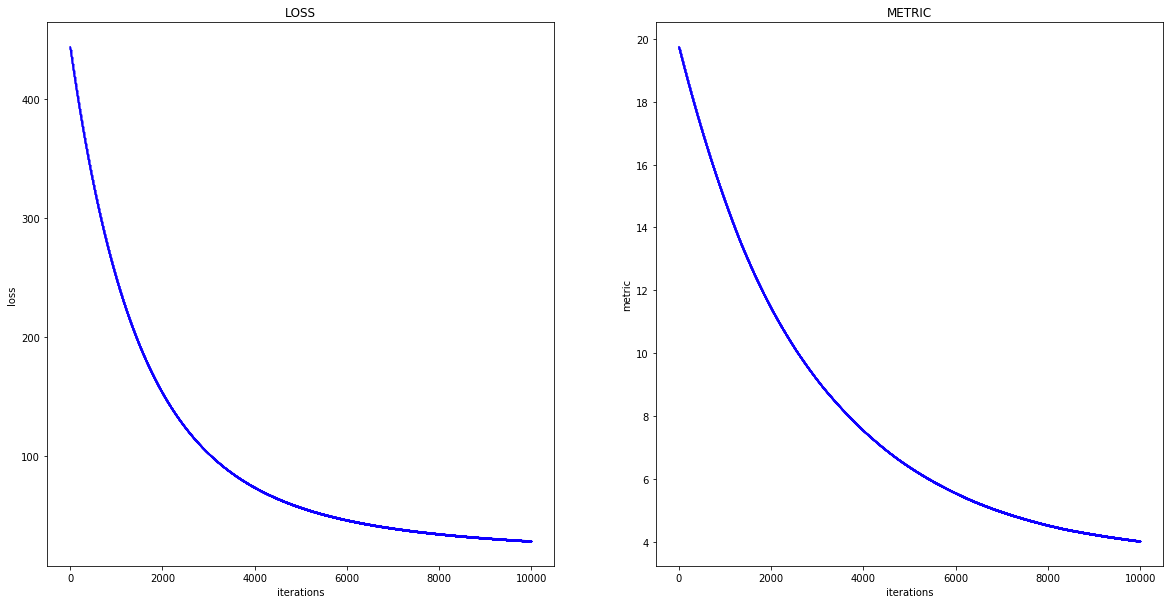

In [16]:
loss = polynomial_regression.history['loss']
metric = polynomial_regression.history['metric']

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('LOSS')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('METRIC')
ax2.set_xlabel('iterations')
ax2.set_ylabel('metric')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')

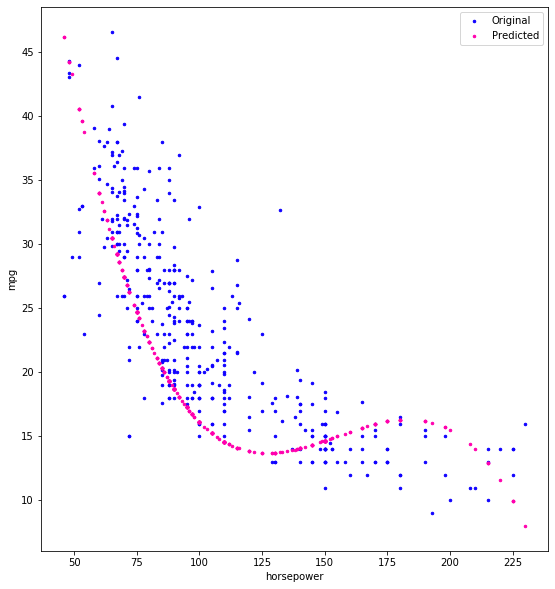

In [17]:
Y_pred = polynomial_regression.predict(X)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('horsepower')
ax.set_ylabel('mpg')
ax.plot(X, Y, marker='.', color='#0F00FF', markersize=5, linestyle='', label='Original')
ax.plot(X, Y_pred, marker='.', color='#FF00AE', markersize=5, linestyle='', label='Predicted')
ax.legend()